<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/RadiopharmaceuticalNetworkALNSALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing From RadiopharmaceuticalNetworkParameters.ipynb**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.8 MB/s eta 0:00:00


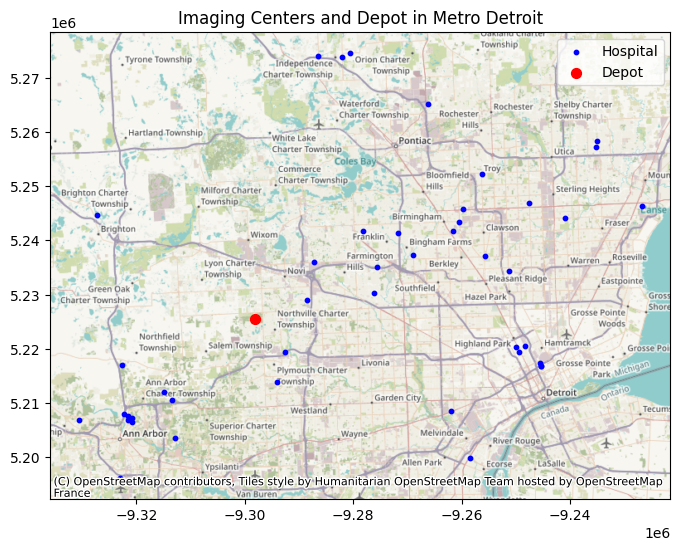

Customer | Delivery (d) | Pickup (p)
------------------------------------
       1 |            1 |          2
       2 |            2 |          8
       3 |            9 |          5
       4 |           10 |         12
       5 |            2 |          9
       6 |           13 |         10
       7 |           10 |          9
       8 |           12 |         14
       9 |           14 |         10
      10 |            9 |          7
      11 |            6 |          5
      12 |            7 |         13
      13 |            8 |         13
      14 |           13 |          2
      15 |            7 |          4
      16 |            3 |          5
      17 |           15 |         10
      18 |            1 |          8
      19 |            1 |         14
      20 |            4 |         13
      21 |            2 |         14
      22 |            4 |          6
      23 |           15 |         14
      24 |           11 |          5
      25 |           14 |          9
 

In [7]:
%run ./RadiopharmaceuticalNetworkParameters.ipynb

# **Initial Algorithm**

In [18]:
class Vehicle:
    def __init__(self, vehicle_id, capacity, speed, cost, depot):
        self.vehicle_id = vehicle_id # unique ID for each vehicle
        self.capacity = capacity #
        self.speed = speed
        self.cost = cost # fixed cost of vehicle
        self.route = [(depot, 0, 0, 0.0)] # (customer_id, delivered, picked_up, arrival_time), starts at depot
        self.current_time = 0

        # Updated Capacity Tracking
        self.full_vials = int(self.capacity * 0.75) # Start with 75% full vials
        self.empty_vials = 0 # Initially no empty vials
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials) # Available space
        self.current_location = depot

    def can_add_customer(self, node, travel_time):
        """
        Check if the vehicle can arrive within the time window.
        Returns (boolean) feasibility flag and expected arrival time.
        """
        # check if the vehicle has capacity
        if self.empty_vials == self.capacity:
            return False, self.current_time # vehicle is full with pickups, can't serve more

        arrival_time = self.current_time + travel_time
        if arrival_time > b[node]: # Too late
            return False, arrival_time
        if arrival_time < a[node]: # Arrive early, wait
            arrival_time = a[node]
        return True, arrival_time

    def add_customer(self, node, delivery_demand, pickup_demand, travel_time):
        """
        Assigns a customer to the vehicle while ensuring delivery before pickup
        and allowing split deliveries.
        """
        # Step 1: Check feasibility (time window constraints)
        feasible, arrival_time = self.can_add_customer(node, travel_time)
        if not feasible:
            return False, delivery_demand, pickup_demand

        # Step 2: Deliver first, and update the vehicle load values
        delivered = min(self.full_vials, delivery_demand)
        self.full_vials -= delivered
        delivery_demand -= delivered
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        # Step 3: Pick up second, and update the vehicle load values
        picked_up = min(self.empty_space, pickup_demand)
        self.empty_vials += picked_up
        pickup_demand -= picked_up
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        # Step 4: Save customer in route & update time
        self.route.append((int(node), int(delivered), int(picked_up), float(arrival_time)))
        self.current_time = arrival_time + s[node]
        self.current_location = node

        # Print Statements
        print(f"Vehicle {self.vehicle_id} visited Customer {node}:")
        print(f"   - Delivered {delivered} (Remaining at customer: {delivery_demand})")
        print(f"   - Picked Up {picked_up} (Remaining at customer: {pickup_demand})")
        print(f"   - Vehicle State: Full Vials = {self.full_vials}, Empty Vials = {self.empty_vials}, Empty Space = {self.empty_space}")


        return True, delivery_demand, pickup_demand

    def return_to_depot(self, depot, t, depot_service_time=30):
        """
        Sends the vehicle back to the depot when full of empty vials.
        Resets load and allows for redeployment.
        """
        if self.current_location == depot:
            return
        travel_time_to_depot = t[self.current_location][depot] # Retrieve from travel time matrix
        self.route.append((depot, 0, 0, self.current_time + travel_time_to_depot)) # Add depot return
        self.current_time += travel_time_to_depot + depot_service_time # Add travel and depot service time

        # Reset vehicle load: Start with 75% full vials, empty vials reset to 0
        self.full_vials = int(self.capacity * 0.75)
        self.empty_vials = 0
        self.empty_space = self.capacity - (self.full_vials + self.empty_vials)

        print(f"Vehicle {self.vehicle_id} returned to depot at time {self.current_time} and reset.")

# visiting order is based on distance to depot
def compute_ordered_route(V_star, depot, distances):
    """
    Computes a heuristic visiting order:
    1. Start with the farthest customer from the depot.
    2. Sequentially add the nearest unvisited customer.
    """
    if not V_star:
        return []

    start_node = max(V_star, key=lambda c: distances[depot][c]) # Start with farthest
    ordered_route = [start_node]
    remaining_nodes = set(V_star) - {start_node}

    while remaining_nodes:
        last_node = ordered_route[-1]
        next_node = min(remaining_nodes, key=lambda c: distances[last_node][c]) # Nearest neighbor
        ordered_route.append(next_node)
        remaining_nodes.remove(next_node)

    return ordered_route

# compute a new ordered route based on proximity to depot (after depot service)
def compute_nearest_ordered_route(V_star, depot, distances):
    """
    Computes a heuristic visiting order:
    1. Start with the closest customer to the depot.
    2. Sequentially add the nearest unvisited customer.
    """
    if not V_star:
        return []

    start_node = min(V_star, key=lambda c: distances[depot][c]) # Start with nearest
    ordered_route = [start_node]
    remaining_nodes = set(V_star) - {start_node}

    while remaining_nodes:
        last_node = ordered_route[-1]
        next_node = min(remaining_nodes, key=lambda c: distances[last_node][c]) # Nearest neighbor
        ordered_route.append(next_node)
        remaining_nodes.remove(next_node)

    return ordered_route

# generates a full solution using the sequential deployment
def generate_sequential_solution(V, V_star, K, Q, d, p, a, b, s, t, depot, distances):
    """
    Deploys vehicles sequentially, prioritizing larger vehicles first.
    If a vehicle is redeployed, it follows a new nearest-neighbor order.
    """
    initial_ordered_route = compute_ordered_route(V_star, depot, distances) # Initial farthest-first order

    # Deploy largest vehicles first
    vehicles = sorted(
        [Vehicle(k, Q[k], vehicle_speed, fixed_costs[k], depot) for k in K],
        key=lambda v: v.capacity,
        reverse=True
    )

    remaining_deliveries = {i: d[i] for i in V_star} # dictionary to track remaining delivery demand
    remaining_pickups = {i: p[i] for i in V_star} # dictionary to track remaining pickup demand

    for vehicle in vehicles:
        print(f"\nDeploying Vehicle {vehicle.vehicle_id} (Capacity {vehicle.capacity})\n")

        current_route = initial_ordered_route[:]

        while True: # Keep redeploying the vehicle until it can’t serve any more customers
            all_customers_served = True # Flag to check if all customers are served

            # skips if fully served
            for customer in current_route[:]:
                if remaining_deliveries[customer] == 0 and remaining_pickups[customer] == 0:
                    continue

                success, new_remaining_delivery, new_remaining_pickup = vehicle.add_customer(
                    customer, remaining_deliveries[customer], remaining_pickups[customer],
                    t[vehicle.current_location][customer]
                )

                if not success:
                    break

                remaining_deliveries[customer] = new_remaining_delivery
                remaining_pickups[customer] = new_remaining_pickup
                all_customers_served = False # At least one customer was served

            vehicle.return_to_depot(depot, t, depot_service_time=30) # 30-min depot service time

            # Check if there are still unfulfilled customers
            if all_customers_served:
                break # No point in redeploying, so exit

            # Compute a new order for redeployment based on nearest-first heuristic
            unserved_customers = [i for i in V_star if remaining_deliveries[i] > 0 or remaining_pickups[i] > 0]
            current_route = compute_nearest_ordered_route(unserved_customers, depot, distances)

    return vehicles, remaining_deliveries, remaining_pickups

# removes consectuive depot visits
def clean_up_route(route):
    cleaned = []
    for i in range(len(route)):
        if i > 0 and route[i][0] == 0 and route[i - 1][0] == 0:
            continue
        cleaned.append(route[i])
    return cleaned

# print function
def print_vehicle_routes_with_costs(vehicles, c):
    total_cost = 0
    print("\nUSED VEHICLE ROUTES & COSTS:")

    for vehicle in vehicles:
        route = clean_up_route(vehicle.route)
        if len(route) <= 1:
            continue  # Skip unused vehicles

        travel_cost = 0
        for i in range(len(route) - 1):
            from_node = route[i][0]
            to_node = route[i + 1][0]
            travel_cost += c[from_node][to_node]

        fixed_cost = vehicle.cost
        total_vehicle_cost = fixed_cost + travel_cost
        total_cost += total_vehicle_cost

        formatted_route = [(int(n), int(d), int(p), float(round(t, 1))) for (n, d, p, t) in route]
        print(f"Vehicle {vehicle.vehicle_id}: Route {formatted_route}, Cost: {round(total_vehicle_cost, 2)}")

    print(f"\nTotal Cost for USED Vehicles: {round(total_cost, 2)}")

In [19]:
# Run the updated solution
vehicles_updated, remaining_deliveries, remaining_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

print("\n✅ Demand Satisfaction Check")
unsatisfied_deliveries = {cust: amt for cust, amt in remaining_deliveries.items() if amt > 0}
unsatisfied_pickups = {cust: amt for cust, amt in remaining_pickups.items() if amt > 0}

if not unsatisfied_deliveries and not unsatisfied_pickups:
    print("All customer demands are satisfied!")
else:
    print("Some customer demands remain unsatisfied!")
    if unsatisfied_deliveries:
        print("Remaining Deliveries:", unsatisfied_deliveries)
    if unsatisfied_pickups:
        print("Remaining Pickups:", unsatisfied_pickups)

print("\n**Vehicle Routes with Costs**")
print_vehicle_routes_with_costs(vehicles_updated, c_matrix_np)


Deploying Vehicle 0 (Capacity 113)

Vehicle 0 visited Customer 4:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 12 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 74, Empty Vials = 12, Empty Space = 27
Vehicle 0 visited Customer 14:
   - Delivered 13 (Remaining at customer: 0)
   - Picked Up 2 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 61, Empty Vials = 14, Empty Space = 38
Vehicle 0 visited Customer 6:
   - Delivered 13 (Remaining at customer: 0)
   - Picked Up 10 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 48, Empty Vials = 24, Empty Space = 41
Vehicle 0 visited Customer 13:
   - Delivered 8 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 40, Empty Vials = 37, Empty Space = 36
Vehicle 0 visited Customer 37:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 10 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 30, Empty Vials = 47, Empty Space = 36
Ve

# **Removal Operators**

# Random Removal

Random removal simply randomly selects a subset of customers from the current solution.

In [20]:
def random_removal(solution, p, original_deliveries, original_pickups, t, s):
    modified_solution = deepcopy(solution)
    all_customers = set()

    # Step 1: Identify all customers
    for vehicle in modified_solution:
        for stop in vehicle.route:
            if stop[0] != 0:
                all_customers.add(stop[0])

    # Step 2: Randomly select customers to remove
    num_to_remove = int(p * len(all_customers))
    customers_to_remove = random.sample(list(all_customers), min(num_to_remove, len(all_customers)))

    # Step 3: Remove those customers from all routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Step 4: Initialize updated demand with original values
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    print("Removed Customers:", sorted(customers_to_remove))

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [21]:
# Random Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s
)

Removed Customers: [5, 16, 17, 25, 26, 30, 32, 37, 39, 40, 41, 43, 44]


# Related Removal

Related removal selects a seed customer at random and removes the customers located closest to it.

In [22]:
# Related Removal
def related_removal(solution, p, original_deliveries, original_pickups, t, s, distances):
    modified_solution = deepcopy(solution)
    all_customers = set()

    # Step 1: Identify all customers in the solution (excluding depot)
    for vehicle in modified_solution:
        for stop in vehicle.route:
            if stop[0] != 0:
                all_customers.add(stop[0])

    if not all_customers:
        return modified_solution, [], original_deliveries, original_pickups

    # Step 2: Choose a seed and identify similar customers (close spatially)
    num_to_remove = int(p * len(all_customers))
    seed_customer = random.choice(list(all_customers))
    related_customers = sorted(all_customers, key=lambda c: distances[seed_customer][c])
    customers_to_remove = related_customers[:min(num_to_remove, len(related_customers))]

    # Step 3: Remove customers from routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Step 4: Reset demand to original
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    print("Removed Customers (Related):", sorted(customers_to_remove))

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [23]:
# Related Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_related, removed_related, updated_deliveries, updated_pickups = related_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s, distance_matrix_np
)

Removed Customers (Related): [1, 3, 9, 13, 16, 22, 24, 25, 34, 38, 40, 41, 42]


# Worst Removal

Worst removal removes customers that contribute the most to the total cost of the solution. This is determined by the value associated with the cost reduction achieved by their removal.

In [24]:
# Worst Removal
def worst_removal(solution, p, original_deliveries, original_pickups, t, s, distances, fixed_costs):
    modified_solution = deepcopy(solution)
    all_customers = set()
    customer_total_cost = {}

    # Extract all customers and calculate cost impact
    for vehicle in modified_solution:
        for i, stop in enumerate(vehicle.route):
            if stop[0] != 0:
                all_customers.add(stop[0])

                # Get previous and next stops
                prev_stop = vehicle.route[i - 1] if i > 0 else (0, 0, 0, 0)
                next_stop = vehicle.route[i + 1] if i < len(vehicle.route) - 1 else (0, 0, 0, 0) # Depot if last stop

                # Compute cost impact: added travel distance and vehicle fixed cost
                cost = (
                    distances[prev_stop[0]][stop[0]] +
                    distances[stop[0]][next_stop[0]] -
                    distances[prev_stop[0]][next_stop[0]] +
                    fixed_costs[vehicle.vehicle_id]
                )

                # Aggregate total cost contribution per customer
                customer_total_cost[stop[0]] = customer_total_cost.get(stop[0], 0) + cost

    if not all_customers:
        return modified_solution, [], remaining_deliveries, remaining_pickups

    num_to_remove = int(p * len(all_customers))

    # Sort customers by total cost contribution in descending order
    sorted_customers = sorted(customer_total_cost.items(), key=lambda x: x[1], reverse=True)

    # Extract the highest-cost customers for removal
    customers_to_remove = [customer for customer, _ in sorted_customers[:min(num_to_remove, len(sorted_customers))]]

    # Remove selected customers from all routes
    for vehicle in modified_solution:
        vehicle.route = [stop for stop in vehicle.route if stop[0] not in customers_to_remove]

    # Set remaining demand of removed customers to original
    updated_deliveries = {i: original_deliveries[i] for i in original_deliveries}
    updated_pickups = {i: original_pickups[i] for i in original_pickups}

    print("Removed Customers (Worst):", sorted(customers_to_remove))

    return modified_solution, customers_to_remove, updated_deliveries, updated_pickups

In [29]:
# Worst Removal Example
original_d = deepcopy(d)
original_p = deepcopy(p)

original_d = {i: d[i] for i in range(len(d))}
original_p = {i: p[i] for i in range(len(p))}

modified_worst, removed_worst, updated_deliveries, updated_pickups = worst_removal(
    vehicles_updated, 0.3, original_d, original_p, t_matrix_np, s, distance_matrix_np, fixed_costs
)

Removed Customers (Worst): [1, 4, 9, 19, 20, 22, 24, 31, 34, 39, 40, 41, 42]


# **Insertion Operators**

We first define a total cost (objective) function and this will be used to test each insertion operator after it is written to simulate it after a random removal operator is applied to the initial solution.

This function calculates the total cost of a vehicle routing solution by summing the fixed costs of all used vehicles and the travel costs between each pair of consecutive stops in their routes. It only includes vehicles that serve at least one customer (i.e., have more than one stop) and rounds the final cost to two decimal places.

In [30]:
def compute_total_cost(solution, c, fixed_costs):
    total_cost = 0

    for vehicle in solution:
        if len(vehicle.route) > 1:
            # Only include fixed cost if the vehicle is used
            total_cost += fixed_costs[vehicle.vehicle_id]

            # Add travel cost
            for i in range(len(vehicle.route) - 1):
                from_node = vehicle.route[i][0]
                to_node = vehicle.route[i + 1][0]
                total_cost += c[from_node][to_node]

    return round(total_cost, 2)

# Parallel Insertion

The parallel insertion heuristic reinserts removed customers into existing routes by evaluating all feasible insertion positions across all vehicles, using a priority queue to prioritize low-cost options. It updates vehicle routes and demand fulfillment in a greedy fashion while ensuring adherence to time windows and capacity constraints, and flags customers with any remaining unmet demand for later handling.

In [53]:
# main greedy reinsertion of removed customers using a priority queue based on cost
def core_parallel_insertion(solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s):
    insertion_heap = [] # priority queue to store candidate insertions
    retry_customers = set() # track customers with remaining unmet demand after initial insertion

    # Ensure all routes start at depot
    for vehicle in solution:
        if not vehicle.route or vehicle.route[0][0] != 0:
            vehicle.route.insert(0, (0, 0, 0, 0.0))
            vehicle.current_time = 0.0

    # loop over every removed customer, every vehicle, and every possible insertion position
    for customer in removed_customers:
        for vehicle in solution:
            for idx in range(len(vehicle.route) - 1):
                prev_stop = vehicle.route[idx][0] # node before insertion point
                next_stop = vehicle.route[idx + 1][0] # node after insertion point
                prev_arrival_time = vehicle.route[idx][3] # the time the vehicle arrives at the previous stop.

                travel_time = t[prev_stop][customer]
                arrival_time = prev_arrival_time + travel_time # arrival time at the insertion point

                # if arrival time too late skip, else stay (maybe wait)
                if arrival_time > b[customer]:
                    continue
                elif arrival_time < a[customer]:
                    arrival_time = a[customer]

                cost = c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop] # insertion cost formula
                max_delivery = min(remaining_deliveries.get(customer, 0), vehicle.full_vials) # how much delivery demand can be satisfied
                predicted_empty_space = vehicle.empty_space + max_delivery # empty space after the delivery is done
                max_pickup = min(remaining_pickups.get(customer, 0), predicted_empty_space) # how much pickup demand can be satisfied

                # if anything can be done, add to the priority queue
                if max_delivery > 0 or max_pickup > 0:
                    heapq.heappush(insertion_heap, (cost, idx, vehicle.vehicle_id, vehicle, customer, max_delivery, max_pickup))

    # process the cheapest insertion
    while insertion_heap:
        _, idx, _, vehicle, customer, delivery, pickup = heapq.heappop(insertion_heap)

        if remaining_deliveries.get(customer, 0) == 0 and remaining_pickups.get(customer, 0) == 0:
            continue # skips if demand is already met

        # final demand check and assign
        assigned_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
        predicted_empty_space = vehicle.empty_space + assigned_delivery
        assigned_pickup = min(remaining_pickups[customer], predicted_empty_space)

        # update the vehicle state
        vehicle.full_vials -= assigned_delivery
        vehicle.empty_vials += assigned_pickup
        vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

        # insert into the route with updated time
        prev_stop = vehicle.route[idx][0]
        prev_time = vehicle.route[idx][3]
        travel_time = t[prev_stop][customer]
        arrival_time = max(prev_time + travel_time, a[customer])
        service_end_time = float(round(arrival_time + s[customer], 2))

        vehicle.route.insert(idx + 1, (customer, assigned_delivery, assigned_pickup, float(round(service_end_time, 2))))

        # shift all later times as a result of adding
        for i in range(idx + 2, len(vehicle.route)):
            prev_stop = vehicle.route[i - 1]
            next_stop = vehicle.route[i][0]
            travel = t[prev_stop[0]][next_stop]
            arrival = max(prev_stop[3] + travel, a[next_stop])
            vehicle.route[i] = (next_stop, vehicle.route[i][1], vehicle.route[i][2], float(round(arrival + s[next_stop], 2)))

        # update demand tracking
        remaining_deliveries[customer] -= assigned_delivery
        remaining_pickups[customer] -= assigned_pickup

        if remaining_deliveries[customer] > 0 or remaining_pickups[customer] > 0:
            retry_customers.add(customer)
        else:
            removed_customers.remove(customer)

    # Final sweep: retry any removed customers who still have unmet demand
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries.get(cust, 0) > 0 or remaining_pickups.get(cust, 0) > 0
        }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

# Recomputes the actual unmet demand from vehicle routes after insertion
def recompute_remaining_demands_from_solution(solution, initial_deliveries, initial_pickups):
    remaining_deliveries = initial_deliveries.copy()
    remaining_pickups = initial_pickups.copy()

    for vehicle in solution:
        for node in vehicle.route:
            cust_id, delivered, picked_up, _ = node
            if cust_id == 0:
                continue # Skip depot
            if cust_id in remaining_deliveries:
                remaining_deliveries[cust_id] -= delivered
            if cust_id in remaining_pickups:
                remaining_pickups[cust_id] -= picked_up

    # Clip negative values to 0 (in case more than expected was served)
    for cust in remaining_deliveries:
        remaining_deliveries[cust] = max(0, remaining_deliveries[cust])
    for cust in remaining_pickups:
        remaining_pickups[cust] = max(0, remaining_pickups[cust])

    return remaining_deliveries, remaining_pickups

In [54]:
# function to apply core_parallel_insertion and final adjustments
def parallel_insertion(solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s):
    deliveries = deepcopy(initial_deliveries)
    pickups = deepcopy(initial_pickups)

    # Step 1: Perform greedy insertion
    parallel_solution, retry_customers, remaining_deliveries, remaining_pickups = core_parallel_insertion(
        solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s)

    # Step 2: Recompute actual remaining demand from final solution
    remaining_deliveries, remaining_pickups = recompute_remaining_demands_from_solution(
        parallel_solution, remaining_deliveries, remaining_pickups
    )

    # Step 3: Final retry set
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0
    }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

In [66]:
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# Random Removal on Initial Solution
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# Parallel Insertion Function on Random Removal
solution, retry_customers, remaining_deliveries, remaining_pickups = parallel_insertion(
    modified_random, removed_random, c_matrix_np, t_matrix_np,
    updated_deliveries, updated_pickups, a, b, s
)

for cust in retry_customers:
        d_amt = remaining_deliveries.get(cust, 0)
        p_amt = remaining_pickups.get(cust, 0)
        print(f"Customer {cust}: Delivery = {d_amt}, Pickup = {p_amt}")

print_vehicle_routes_with_costs(solution, c_matrix_np)

Removed Customers: [8, 10, 15, 18, 19, 22, 23, 24, 29, 32, 38, 41, 42]

USED VEHICLE ROUTES & COSTS:
Vehicle 0: Route [(0, 0, 0, 0.0), (4, 10, 12, 420.0), (14, 13, 2, 510.0), (6, 13, 10, 540.8), (13, 8, 13, 582.2), (37, 10, 10, 617.4), (36, 7, 4, 654.9), (18, 1, 8, 690.2), (25, 14, 9, 722.1), (16, 3, 5, 753.5), (9, 5, 10, 789.1), (1, 0, 2, 822.9), (34, 0, 1, 864.0), (40, 0, 2, 895.1), (22, 4, 6, 926.3), (0, 0, 0, 962.1), (31, 10, 3, 998.3), (0, 0, 0, 1004.5)], Cost: 298.26
Vehicle 6: Route [(0, 0, 0, 0.0), (9, 9, 0, 450.0), (1, 1, 0, 483.8), (34, 10, 0, 555.0), (40, 10, 0, 586.1), (41, 6, 7, 619.4), (42, 1, 9, 649.5), (24, 11, 5, 680.1), (3, 9, 5, 726.1), (38, 5, 1, 762.9), (0, 0, 0, 792.4), (7, 10, 9, 830.0), (5, 2, 9, 865.2), (33, 2, 3, 903.2), (12, 7, 13, 937.9), (35, 1, 7, 971.5), (28, 7, 7, 1006.8), (0, 0, 0, 1024.8)], Cost: 259.62
Vehicle 4: Route [(0, 0, 0, 0.0), (17, 15, 10, 480.0), (11, 6, 5, 527.9), (21, 2, 14, 572.5), (26, 15, 12, 639.6), (19, 1, 14, 670.2), (29, 4, 11, 700.

# Regret Split Insertion

The regret split insertion heuristic reassigns removed customers by evaluating multiple feasible insertion points across all routes and computing a regret value based on the difference between the best and second-best insertion costs. Customers with higher regret are prioritized for reinsertion, ensuring that opportunities for low-cost insertions are not missed.

In [107]:
# Core Regret Split Insertion
def core_regret_split_insertion(solution, removed_customers, c, t, remaining_deliveries, remaining_pickups, a, b, s):
    insertion_candidates = {} # stores potential insertion positions for each customer
    retry_customers = set() # if a customer has no valid positions, add them here

    # Step 1: Build candidate insertions
    for customer in removed_customers:
        positions = []
        for vehicle in solution:
            # try inserting customer between every two stops
            for idx in range(len(vehicle.route) - 1):
                prev_stop = vehicle.route[idx][0]
                next_stop = vehicle.route[idx + 1][0]
                prev_arrival_time = vehicle.route[idx][3]

                travel_time = t[prev_stop][customer]
                arrival_time = prev_arrival_time + travel_time

                # respect time window constraints
                if arrival_time > b[customer]:
                    continue
                if arrival_time < a[customer]:
                    arrival_time = a[customer]

                # compute max feasible delivery and pickup amounts
                feasible_delivery = min(remaining_deliveries[customer], vehicle.full_vials)
                feasible_pickup = min(remaining_pickups[customer], vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + feasible_delivery))

                if feasible_delivery == 0 and feasible_pickup == 0:
                    continue

                # compute insertion cost and then the score
                cost = c[prev_stop][customer] + c[customer][next_stop] - c[prev_stop][next_stop]
                served = feasible_delivery + feasible_pickup
                score = cost / served

                positions.append((score, cost, idx, vehicle.vehicle_id, vehicle, feasible_delivery, feasible_pickup))

        # store valid positions or mark customer as uninsertable (for now)
        if positions:
            positions.sort() # sort by score (lowest regret first)
            insertion_candidates[customer] = positions
        else:
            retry_customers.add(customer)

    # Step 2: Regret prioritization of which customers to insert
    regret_heap = []

    # do the regret formula and then sort from max value down
    for customer, options in insertion_candidates.items():

        # Regret value = difference between best and second-best cost
        regret_value = options[1][1] - options[0][1] if len(options) > 1 else float("inf")
        heapq.heappush(regret_heap, (-regret_value, customer)) # Max-heap by regret

    # Step 3: Insert based on regret
    while regret_heap:
        _, customer = heapq.heappop(regret_heap)
        options = insertion_candidates[customer]
        total_delivery = remaining_deliveries[customer]
        total_pickup = remaining_pickups[customer]

        # try inserting the customer in best positions
        for _, _, idx, _, vehicle, feasible_delivery, feasible_pickup in options:
            if total_delivery == 0 and total_pickup == 0:
                break

            # recalculate feasibility and update load values
            feasible_delivery = min(total_delivery, vehicle.full_vials)
            feasible_pickup = min(total_pickup, vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials + feasible_delivery))
            if feasible_delivery == 0 and feasible_pickup == 0:
                continue

            vehicle.full_vials -= feasible_delivery
            vehicle.empty_vials += feasible_pickup
            vehicle.empty_space = vehicle.capacity - (vehicle.full_vials + vehicle.empty_vials)

            vehicle.route.insert(idx + 1, (customer, feasible_delivery, feasible_pickup, vehicle.current_time))

            # Update future stop times (updates the current time value from above)
            for i in range(idx + 2, len(vehicle.route)):
                prev = vehicle.route[i - 1]
                nxt = vehicle.route[i][0]
                arrival = max(prev[3] + t[prev[0]][nxt], a[nxt])
                vehicle.route[i] = (nxt, vehicle.route[i][1], vehicle.route[i][2], arrival + s[nxt])

            total_delivery -= feasible_delivery
            total_pickup -= feasible_pickup

        remaining_deliveries[customer] = total_delivery
        remaining_pickups[customer] = total_pickup

        # if any demand remains, flag for retry
        if total_delivery > 0 or total_pickup > 0:
            retry_customers.add(customer)

    # Final sweep: retry any removed customers who still have unmet demand
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries.get(cust, 0) > 0 or remaining_pickups.get(cust, 0) > 0
        }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

# Recomputes what demand is still unmet based on solution routes
def recompute_remaining_demands_from_solution(solution, initial_deliveries, initial_pickups):
    remaining_deliveries = initial_deliveries.copy()
    remaining_pickups = initial_pickups.copy()

    for vehicle in solution:
        for node in vehicle.route:
            cust_id, delivered, picked_up, _ = node
            if cust_id == 0:
                continue # Skip depot
            if cust_id in remaining_deliveries:
                remaining_deliveries[cust_id] -= delivered
            if cust_id in remaining_pickups:
                remaining_pickups[cust_id] -= picked_up

    # Clip negative values to 0 (in case more than expected was served)
    for cust in remaining_deliveries:
        remaining_deliveries[cust] = max(0, remaining_deliveries[cust])
    for cust in remaining_pickups:
        remaining_pickups[cust] = max(0, remaining_pickups[cust])

    return remaining_deliveries, remaining_pickups

In [108]:
# Full function for regret split insertion heuristic
def regret_split_insertion(solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s):
    deliveries = deepcopy(initial_deliveries)
    pickups = deepcopy(initial_pickups)

    # Step 2: Perform greedy insertion
    parallel_solution, retry_customers, remaining_deliveries, remaining_pickups = core_regret_split_insertion(
        solution, removed_customers, c, t, initial_deliveries, initial_pickups, a, b, s)

    # Step 3: Recompute actual remaining demand from final solution
    remaining_deliveries, remaining_pickups = recompute_remaining_demands_from_solution(
        parallel_solution, remaining_deliveries, remaining_pickups
    )

    # Step 4: Final retry set
    retry_customers = {
        cust for cust in remaining_deliveries
        if remaining_deliveries[cust] > 0 or remaining_pickups[cust] > 0
    }

    return solution, retry_customers, remaining_deliveries, remaining_pickups

In [117]:
### TEST
# Convert delivery and pickup lists to dictionaries
initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

# 1. Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# 2. Regret Split!
solution, retry_customers, remaining_deliveries, remaining_pickups = regret_split_insertion(
    modified_random, removed_random, c_matrix_np, t_matrix_np, updated_deliveries, updated_pickups, a, b, s
)

for cust in retry_customers:
        d_amt = remaining_deliveries.get(cust, 0)
        p_amt = remaining_pickups.get(cust, 0)
        print(f"Customer {cust}: Delivery = {d_amt}, Pickup = {p_amt}")

print_vehicle_routes_with_costs(solution, c_matrix_np)

Removed Customers: [1, 8, 14, 20, 23, 27, 28, 30, 31, 34, 40, 41, 42]

USED VEHICLE ROUTES & COSTS:
Vehicle 0: Route [(0, 0, 0, 0.0), (1, 1, 2, 1255.3), (4, 10, 12, 1305.5), (14, 13, 2, 1255.3), (6, 13, 10, 1286.1), (13, 8, 13, 1327.5), (37, 10, 10, 1362.7), (36, 7, 4, 1400.2), (18, 1, 8, 1435.6), (25, 14, 9, 1467.5), (16, 3, 5, 1498.9), (9, 5, 10, 1534.4), (22, 0, 6, 1577.5), (24, 0, 5, 1611.3), (0, 0, 0, 1650.5)], Cost: 297.44
Vehicle 6: Route [(0, 0, 0, 0.0), (9, 9, 0, 450.0), (22, 4, 0, 524.2), (40, 10, 2, 1188.7), (34, 10, 1, 1219.7), (24, 11, 0, 1252.9), (41, 6, 7, 1283.3), (42, 1, 9, 1313.4), (38, 5, 1, 1357.2), (3, 9, 5, 1394.0), (31, 10, 3, 1452.9), (0, 0, 0, 1459.1), (7, 10, 9, 1496.7), (5, 2, 9, 1531.9), (28, 7, 7, 1570.5), (33, 2, 3, 1605.8), (12, 7, 13, 1640.5), (35, 1, 7, 1674.1), (0, 0, 0, 1697.4)], Cost: 260.39
Vehicle 4: Route [(0, 0, 0, 0.0), (17, 15, 10, 480.0), (11, 6, 5, 527.9), (21, 2, 14, 572.5), (8, 0, 2, 1240.2), (26, 15, 12, 1275.9), (29, 4, 11, 1306.4), (19, 

# Savings Insertion

The savings insertion heuristic is a clustering-based vehicle routing strategy that merges customer routes based on potential cost "savings" from serving them together rather than individually. It begins by grouping customers into singleton clusters, calculates feasible merges based on time windows, delivery/pickup capacity, and route efficiency, and gradually builds larger routes while injecting depot returns into routes when necessary.

In [121]:
from datetime import datetime

In [118]:
# Resolves any overlapping customers in the initial cluster list.
# Ensures that each customer appears in only one cluster by randomly selecting
# one cluster to keep the customer and removing the customer from the others.

def resolve_cluster_overlap(clusters):
    customer_to_clusters = defaultdict(list)

    # Map each customer to all clusters they appear in
    for cluster in clusters:
        for cust in cluster['customers']:
            customer_to_clusters[cust].append(cluster)

    # For customers in multiple clusters, keep them in one and remove from others
    for cust, cluster_list in customer_to_clusters.items():
        if len(cluster_list) > 1:
            chosen = random.choice(cluster_list)
            for cluster in cluster_list:
                if cluster is not chosen and cust in cluster['customers']:
                    cluster['customers'].remove(cust)

    # Clean up empty clusters
    clusters = [c for c in clusters if c['customers']]
    return clusters

# prints the clusters post-overlap
def print_all_clusters(clusters, label="Current Clusters"):
    print(f"\n{label} — Total: {len(clusters)}")
    for idx, cluster in enumerate(clusters):
        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])
        print(f"  Cluster {idx}: {route} (Delivery: {round(cluster['delivery_load'], 2)}, Pickup: {round(cluster['pickup_load'], 2)})")

In [126]:
### CLUSTER CLUSTER MERGE

# Checks whether a proposed route satisfies all time window constraints.
def is_time_feasible_route(route, a, b, s, t):
    time = 0
    current_node = route[0]

    for next_node in route[1:]:
        travel_time = t[current_node][next_node]
        arrival_time = time + travel_time
        arrival_time = max(arrival_time, a[next_node]) # wait if vehicle arrives early

        if arrival_time > b[next_node]: # violated time window
            return False

        time = arrival_time + s[next_node]
        current_node = next_node

    return True

# Checks whether a proposed route satisfies delivery/pickup feasibility based on vehicle capacity
def is_cluster_cluster_capacity_feasible(route, deliveries, pickups, capacity):
    full_vials = 0.75 * capacity
    empty_vials = 0

    for node in route[1:]: # skip starting depot
        if node == 0:
            # Mid-route depot reset
            full_vials = 0.75 * capacity # vehicle starts 75% full
            empty_vials = 0
            continue

        demand_delivery = deliveries.get(node, 0)
        demand_pickup = pickups.get(node, 0)

        # Capacity constraint: can't fulfill full delivery
        if full_vials < demand_delivery:
            return False

        # Simulate delivery
        full_vials -= demand_delivery

        # Check if there's room to pick up all used vials
        space_left = capacity - (full_vials + empty_vials)
        if space_left < demand_pickup:
            return False

        # Simulate pickup
        empty_vials += demand_pickup

    return True

# # Builds a greedy route starting from the depot and inserting nearest unvisited customers
def build_greedy_merge_route(customers, t_matrix):
    route = [0] # start at depot
    unvisited = set(customers)
    current = 0

    while unvisited:
        next_customer = min(unvisited, key=lambda c: t_matrix[current][c])
        route.append(next_customer)
        unvisited.remove(next_customer)
        current = next_customer

    route.append(0) # return to depot
    return route

# Tries to merge two clusters into one feasible route
def cluster_cluster_merge(cluster1, cluster2, deliveries, pickups, capacity, a, b, s, t):
    customers = list(set(cluster1 + cluster2))
    route = build_greedy_merge_route(customers, t)

    # # First attempt: normal route
    if is_time_feasible_route(route, a, b, s, t):
        if is_cluster_cluster_capacity_feasible(route, deliveries, pickups, capacity):
            return route

        # Second attempt: try inserting depot mid-route
        for i in range(1, len(route)-1):
            route_with_depot = route[:i] + [0] + route[i:]
            if is_time_feasible_route(route_with_depot, a, b, s, t) and \
               is_cluster_cluster_capacity_feasible(route_with_depot, deliveries, pickups, capacity):
                return route_with_depot

    return None # merge not feasible

# Iteratively attempts to merge clusters using greedy savings logic and available vehicles
def merge_clusters_stepwise(clusters, deliveries, pickups, vehicles_available, a, b, s, t):
    available_vehicles = sorted(vehicles_available, key=lambda v: v.capacity, reverse=True)
    merged = True

    # Helper: generates arrival times for a route
    def simulate_route_with_timestamps(route):
        time = 0
        current_node = route[0]
        timestamps = [(current_node, time)]

        for next_node in route[1:]:
            travel_time = t[current_node][next_node]
            arrival_time = time + travel_time
            arrival_time = max(arrival_time, a[next_node])
            timestamps.append((next_node, round(arrival_time, 2)))
            time = arrival_time + s[next_node]
            current_node = next_node

        return timestamps

    # computes total demand of a cluster
    def cluster_total_demand(cluster):
        return cluster['delivery_load'] + cluster['pickup_load']

    # keep merging until no more valid merges or no more vehicles
    while merged and len(available_vehicles) > 0:
        merged = False
        clusters.sort(key=cluster_total_demand, reverse=True)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                # Skip clusters that are just singletons
                if len(clusters[i]['customers']) <= 1 or len(clusters[j]['customers']) <= 1:
                    continue

                cluster_i = clusters[i]
                cluster_j = clusters[j]

                cluster1 = cluster_i['customers']
                cluster2 = cluster_j['customers']
                candidate_vehicle = available_vehicles[0]

                # Try to merge the two clusters into a feasible route
                merged_route = cluster_cluster_merge(
                    cluster1, cluster2,
                    deliveries, pickups,
                    candidate_vehicle.capacity,
                    a, b, s, t
                )

                if merged_route:
                    # Build new merged cluster
                    new_customers = [c for c in merged_route if c != 0]
                    new_cluster = {
                        'customers': new_customers,
                        'delivery_load': sum(deliveries.get(c, 0) for c in new_customers),
                        'pickup_load': sum(pickups.get(c, 0) for c in new_customers),
                        'assigned_vehicle': candidate_vehicle
                    }

                    time_str = datetime.now().strftime("%H:%M:%S")
                    print(f"\n [{time_str}] Merged clusters with customers {cluster1} and {cluster2} → Assigned Vehicle {candidate_vehicle.vehicle_id}")
                    print("New Merged Cluster:")
                    print(f"  ➤ {new_customers} (Delivery: {new_cluster['delivery_load']}, Pickup: {new_cluster['pickup_load']})")

                    print("Arrival Timeline:")
                    timestamps = simulate_route_with_timestamps(merged_route)
                    for cust_id, arr_time in timestamps:
                        print(f"     ➤ Node {cust_id}: Arrives at {arr_time:.2f} min")

                    # Remove used vehicle and clusters by object reference
                    available_vehicles.pop(0)
                    clusters.remove(cluster_i)
                    clusters.remove(cluster_j)
                    clusters.append(new_cluster)
                    merged = True
                    break
            if merged:
                break

        print(f"\n Clusters After Merge Step — Total: {len(clusters)}")
        print_all_clusters(clusters)

    return clusters, available_vehicles

In [138]:
### CLUSTER SINGLETON MERGE
def merge_cluster_singletons(clusters, deliveries, pickups, available_vehicles, a, b, s, c, t):

    # Simulates a route and returns timestamped arrival times at each node
    def simulate_route_with_timestamps(route):
        time = 0
        current_node = route[0]
        timestamps = [(current_node, time)]

        for next_node in route[1:]:
            travel_time = t[current_node][next_node]
            arrival_time = max(time + travel_time, a[next_node])
            timestamps.append((next_node, round(arrival_time, 2)))
            time = arrival_time + s[next_node]
            current_node = next_node

        return timestamps

    # Simulates delivery/pickup feasibility along a route, allowing mid-route depot resets
    def simulate_capacity_with_depot_return(route, deliveries, pickups, capacity):
        full = 0.75 * capacity
        empty = 0
        demand_served = {}

        for node in route[1:]:
            if node == 0:
                # Reset capacity at depot (75%)
                full = 0.75 * capacity
                empty = 0
                continue

            d = deliveries.get(node, 0)
            p = pickups.get(node, 0)

            d_fulfilled = min(full, d)
            full -= d_fulfilled

            space_left = capacity - (full + empty)
            p_fulfilled = min(space_left, p)
            empty += p_fulfilled

            if node not in demand_served:
                demand_served[node] = (0, 0)
            prev_d, prev_p = demand_served[node]
            demand_served[node] = (prev_d + d_fulfilled, prev_p + p_fulfilled)

            # If not fully served, force reset at next depot
            if d_fulfilled < d or p_fulfilled < p:
                full = 0.75 * capacity
                empty = 0

        return True, demand_served

    # Separate out singletons (1 customer) and full clusters (2+ customers)
    singletons = [c for c in clusters if len(c['customers']) == 1]
    full_clusters = [c for c in clusters if len(c['customers']) > 1]

    # Track which vehicles are already used
    used_vehicles = set(cluster.get('assigned_vehicle') for cluster in clusters if cluster.get('assigned_vehicle'))

    # Loop over each singleton to find best cluster to merge into
    for singleton in singletons:
        node = singleton['customers'][0]
        best_cluster = None
        best_route = None
        best_cost = float('inf')
        best_demand_served = {}
        best_vehicle = None

        # Try inserting singleton into each full cluster
        for cluster in full_clusters:
            base = cluster['customers']
            vehicle = cluster.get('assigned_vehicle')

            # Assign a vehicle if cluster doesn't already have one
            if not vehicle:
                if available_vehicles:
                    vehicle = available_vehicles.pop(0)
                    used_vehicles.add(vehicle)
                    cluster['assigned_vehicle'] = vehicle
                else:
                    continue

            capacity = vehicle.capacity

            # Try all possible insertion points for the singleton
            for i in range(len(base) + 1):
                trial = [0] + base[:i] + [node] + base[i:] + [0]

                # Skip if time windows are violated
                if not is_time_feasible_route(trial, a, b, s, t):
                    continue

                # Simulate fulfillment and track how much demand is served
                feasible, served = simulate_capacity_with_depot_return(trial, deliveries, pickups, capacity)
                if feasible or node in served:
                    cost = sum(c[trial[i]][trial[i + 1]] for i in range(len(trial) - 1))
                    if cost < best_cost:
                        best_cost = cost
                        best_route = trial
                        best_cluster = cluster
                        best_demand_served = served
                        best_vehicle = vehicle

        # Apply the best merge found, if one exists
        if best_cluster and best_route:
            merged_customers = [n for n in best_route if n != 0]
            best_cluster['customers'] = merged_customers
            best_cluster['delivery_load'] = sum(deliveries.get(n, 0) for n in merged_customers)
            best_cluster['pickup_load'] = sum(pickups.get(n, 0) for n in merged_customers)
            best_cluster['assigned_vehicle'] = best_vehicle

            # Print arrival timeline
            time_str = datetime.now().strftime("%H:%M:%S")
            print(f"\n[{time_str}] Inserted singleton {node} into cluster {best_cluster['customers']}")
            print(f"New Merged Cluster: {merged_customers}")
            print("Arrival Timeline:")
            for n, arr in simulate_route_with_timestamps(best_route):
                print(f"     ➤ Node {n}: Arrives at {arr:.2f} min")

            # Update or remove singleton based on partial or full fulfillment
            d_served, p_served = best_demand_served.get(node, (0, 0))
            remaining_d = deliveries[node] - d_served
            remaining_p = pickups[node] - p_served
            if remaining_d > 0 or remaining_p > 0:
                print(f"Partially served singleton {node}, remaining delivery: {remaining_d}, pickup: {remaining_p}")
                singleton['delivery_load'] = remaining_d
                singleton['pickup_load'] = remaining_p
            else:
                clusters.remove(singleton)

        else:
            print(f"\nCould not insert singleton {node} into any cluster.")

    print(f"\nClusters After Singleton Merge — Total: {len(clusters)}")
    print_all_clusters(clusters)
    return clusters, available_vehicles

# Prints the assigned vehicle (if any) for each cluster
def print_vehicle_assignments(clusters):
    print("\nVehicle Assignments:")
    for i, cluster in enumerate(clusters):
        assigned = cluster.get('assigned_vehicle', None)
        if assigned:
            print(f"  Vehicle {assigned.vehicle_id} → Cluster {i}: {cluster['customers']}")
        else:
            print(f"  Unassigned → Cluster {i}: {cluster['customers']}")

In [141]:
### SINGLETON SINGLETON MERGE
def merge_singleton_singletons(clusters, deliveries, pickups, available_vehicles, a, b, s, c, t):

    # Helper: compute total demand of a cluster
    def total_demand(cluster):
        return cluster['delivery_load'] + cluster['pickup_load']

    # Step 1: Identify all singleton clusters (i.e., clusters with only 1 customer)
    singletons = [c for c in clusters if len(c['customers']) == 1]
    if len(singletons) < 2:
        return clusters, available_vehicles # Nothing to merge

    # Step 2: Sort singleton clusters in descending order of demand (priority to serve largest demand first)
    singletons.sort(key=total_demand, reverse=True)

    # Step 3: Pick the top two highest-demand singletons
    s1, s2 = singletons[:2]
    c1 = s1['customers'][0]
    c2 = s2['customers'][0]

    # Step 4: Compare both route options: depot → c1 → c2 → depot vs depot → c2 → c1 → depot
    route1 = [0, c1, c2, 0]
    route2 = [0, c2, c1, 0]

    cost1 = sum(c[route1[i]][route1[i+1]] for i in range(len(route1)-1))
    cost2 = sum(c[route2[i]][route2[i+1]] for i in range(len(route2)-1))

    best_route = route1 if cost1 < cost2 else route2
    merged_customers = [n for n in best_route if n != 0]

    # Step 5: Assign a vehicle to the new cluster (if any are available)
    if available_vehicles:
        vehicle = available_vehicles.pop(0)
    else:
        print("\nNo available vehicles for singleton-singleton merge.")
        return clusters, available_vehicles

    # Step 6: Build the new merged cluster
    new_cluster = {
        'customers': merged_customers,
        'delivery_load': sum(deliveries.get(n, 0) for n in merged_customers),
        'pickup_load': sum(pickups.get(n, 0) for n in merged_customers),
        'assigned_vehicle': vehicle
    }

    # Step 7: Print timestamp and arrival info
    time_str = datetime.now().strftime("%H:%M:%S")
    print(f"\n[{time_str}] Singleton-Singleton Merge: {c1} + {c2} → {merged_customers} with Vehicle {vehicle.vehicle_id}")
    print("Arrival Timeline:")
    time = 0
    current = 0
    for node in merged_customers:
        travel = t[current][node]
        arrival = max(time + travel, a[node])
        print(f"     ➤ Node {node}: Arrives at {arrival:.2f} min")
        time = arrival + s[node]
        current = node

    # Step 8: Remove old singleton clusters from the list and insert the merged one
    clusters.remove(s1)
    clusters.remove(s2)
    clusters.append(new_cluster)

    # Step 9: Recursively call cluster-singleton merge in case remaining singletons can now be merged into full clusters
    return merge_cluster_singletons(
        clusters,
        deliveries,
        pickups,
        available_vehicles,
        a, b, s, c, t
    )

In [143]:
### RUN THRU FINAL ROUTES
def apply_final_fulfillment(clusters, deliveries, pickups, s, t):
    print("\nApplying Final Fulfillment Across All Clusters...")

    # Loop through each cluster to simulate the actual fulfillment process
    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            print(f"Skipping unassigned cluster: {cluster['customers']}")
            continue # Skip clusters without an assigned vehicle

        route = [0] + cluster['customers'] + [0]
        full = 0.75 * vehicle.capacity # Initial full vials at start
        empty = 0 # Initial empty vials

        print(f"\nVehicle {vehicle.vehicle_id} Route: {route}")

        # Iterate over each stop in the route (excluding starting depot)
        for idx, node in enumerate(route[1:], start=1):
            if node == 0:
                # Depot reset
                full = 0.75 * vehicle.capacity
                empty = 0
                continue

            # Fulfill delivery
            delivery_needed = deliveries.get(node, 0)
            delivered = min(full, delivery_needed)
            deliveries[node] -= delivered
            full -= delivered

            # Fulfill pickup
            pickup_needed = pickups.get(node, 0)
            space_left = vehicle.capacity - (full + empty)
            picked_up = min(space_left, pickup_needed)
            pickups[node] -= picked_up
            empty += picked_up

            print(f"  ➤ Node {node}: Delivered = {delivered}, Pickup = {picked_up}, Remaining Delivery = {round(deliveries[node], 2)}, Remaining Pickup = {round(pickups[node], 2)}")

def collect_singleton_clusters(clusters):
    singletons = []

    # Collect clusters that contain exactly one customer and have no assigned vehicle
    for cluster in clusters:
        if (
            len(cluster.get('customers', [])) == 1
            and cluster.get('assigned_vehicle') is None
        ):
            singletons.append(cluster)
    return singletons

In [152]:
### INJECTS THE DEPOT IN
def inject_depot_after_last_full_fulfillment(clusters, deliveries, pickups):

    # Inserts a depot visit after the last customer with zero remaining delivery/pickup
    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = [0] + cluster['customers'] + [0]
        cluster['original_route'] = route[:] # Save the original route!

        # Track the last node where both delivery and pickup are 0
        last_fulfilled_index = 0
        for i in range(1, len(route) - 1): # skip depots
            node = route[i]
            if deliveries.get(node, 0) == 0 and pickups.get(node, 0) == 0:
                last_fulfilled_index = i

        # Inject depot AFTER that node, if it's not the last node before return
        if last_fulfilled_index < len(route) - 2:
            injected_route = route[:last_fulfilled_index + 1] + [0] + route[last_fulfilled_index + 1:]
        else:
            injected_route = route

        cluster['route_with_depots'] = injected_route

def print_cluster_routes_with_injected_depots(clusters):
    # Print all cluster routes after depot injection
    print("\nRoutes After Injecting Depot Post-Fulfillment:")
    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])
        print(f"Vehicle {vehicle.vehicle_id} Route: {route}")

def is_route_time_feasible(route, a, b, s, t_matrix):
    # Check time window feasibility for a route
    current_time = 0
    for i in range(1, len(route)):
        prev_node = route[i - 1]
        curr_node = route[i]
        travel_time = t_matrix[prev_node][curr_node]
        arrival_time = max(current_time + travel_time, a[curr_node])
        if arrival_time > b[curr_node]:
            return False
        current_time = arrival_time + s[curr_node]
    return True

def check_cluster_time_feasibility(clusters, a, b, s, t_matrix):
    # Print whether each cluster's route is feasible after depot injection
    print("\nTime Window Feasibility Check After Depot Injection:")

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            print(f"  Skipping unassigned cluster: {cluster['customers']}")
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])
        feasible = is_route_time_feasible(route, a, b, s, t_matrix)

        status = "Feasible!" if feasible else "Not Feasible"
        print(f"Vehicle {vehicle.vehicle_id} Route: {route} → {status}")

def simulate_full_fulfillment_for_feasible_clusters(clusters, deliveries, pickups, s, t_matrix):
    # Simulates delivery/pickup and prints fulfillment results for feasible routes
    print("\nFull Fulfillment Check for Feasible Routes:")

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue # skip clusters with no vehicle

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])

        # Check time feasibility first
        if not is_route_time_feasible(route, a, b, s, t_matrix):
            print(f"Vehicle {vehicle.vehicle_id} -> Skipped (Not Feasible)")
            continue

        full = 0.75 * vehicle.capacity
        empty = 0

        local_deliveries = deepcopy(deliveries)
        local_pickups = deepcopy(pickups)

        all_fulfilled = True
        print(f"\nVehicle {vehicle.vehicle_id} Route: {route}")

        for node in route[1:]:
            if node == 0:
                full = 0.75 * vehicle.capacity
                empty = 0
                print("Returned to Depot: Reset full = {:.2f}, empty = {:.2f}".format(full, empty))
                continue

            d_needed = local_deliveries.get(node, 0)
            p_needed = local_pickups.get(node, 0)

            d_fulfilled = min(full, d_needed)
            full -= d_fulfilled
            local_deliveries[node] -= d_fulfilled

            space_left = vehicle.capacity - (full + empty)
            p_fulfilled = min(space_left, p_needed)
            empty += p_fulfilled
            local_pickups[node] -= p_fulfilled

            print(f"  ➤ Node {node}: Delivered = {d_fulfilled}, Pickup = {p_fulfilled}, Remaining Delivery = {local_deliveries[node]}, Remaining Pickup = {local_pickups[node]}")

            if local_deliveries[node] > 0 or local_pickups[node] > 0:
                all_fulfilled = False

        status = "All Demands Fulfilled" if all_fulfilled else "Unmet Demand"
        print(f"Result: {status}")

# Identifies unfulfilled customers and creates new singleton clusters for them.
def collect_unfulfilled_customers(clusters, deliveries, pickups, s, t_matrix, a, b):
    new_clusters = [] # Will hold the output singleton clusters
    residuals = [] # Temporarily collect unmet demand per customer

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots', [0] + cluster['customers'] + [0])

        # Only proceed if route is time feasible
        if not is_route_time_feasible(route, a, b, s, t_matrix):
            continue

        full = 0.75 * vehicle.capacity
        empty = 0

        local_deliveries = deepcopy(deliveries)
        local_pickups = deepcopy(pickups)

        for node in route[1:]:
            if node == 0:
                full = 0.75 * vehicle.capacity
                empty = 0
                continue

            d_needed = local_deliveries.get(node, 0)
            p_needed = local_pickups.get(node, 0)

            d_fulfilled = min(full, d_needed)
            full -= d_fulfilled
            local_deliveries[node] -= d_fulfilled

            space_left = vehicle.capacity - (full + empty)
            p_fulfilled = min(space_left, p_needed)
            empty += p_fulfilled
            local_pickups[node] -= p_fulfilled

            # If any remaining, save for new cluster
            if local_deliveries[node] > 0 or local_pickups[node] > 0:
                residuals.append({
                    'customer': node,
                    'delivery_load': round(local_deliveries[node], 2),
                    'pickup_load': round(local_pickups[node], 2)
                })

    # Create clusters from residuals
    for r in residuals:
        new_clusters.append({
            'customers': [r['customer']],
            'delivery_load': r['delivery_load'],
            'pickup_load': r['pickup_load'],
            'assigned_vehicle': None
        })

    return new_clusters

# time infeasible routes!
def analyze_infeasible_clusters(clusters, a, b, s, t_matrix):
    print("\nAnalyzing Time-Infeasible Clusters...")

    for cluster in clusters:
        vehicle = cluster.get('assigned_vehicle')
        if not vehicle:
            continue

        route = cluster.get('route_with_depots') or cluster.get('original_route', [0] + cluster['customers'] + [0])
        if is_route_time_feasible(route, a, b, s, t_matrix):
            continue # only care about infeasible ones

        print(f"\nVehicle {vehicle.vehicle_id} (Infeasible Route): {route}")
        current_time = 0

        for i in range(1, len(route)):
            prev_node = route[i - 1]
            curr_node = route[i]
            travel_time = t_matrix[prev_node][curr_node]
            arrival_time = max(current_time + travel_time, a[curr_node])

            # Print timeline
            print(f"  ➤ Node {curr_node}: ETA = {arrival_time:.2f} (Allowed: {a[curr_node]} - {b[curr_node]})")

            # Check violation
            if arrival_time > b[curr_node]:
                print(f"    Time window violated at Node {curr_node} — Arrival: {arrival_time:.2f}, Latest: {b[curr_node]}")
                break

            current_time = arrival_time + s[curr_node]

# Splits clusters with time-infeasible routes into two parts:
# - Head: the feasible part before the violation (kept in original cluster)
# - Tail: the rest after the violation (turned into new singleton clusters)
def split_infeasible_route_at_violation(clusters, a, b, s, t_matrix):
    new_tail_clusters = []

    for cluster in clusters:
        vehicle = cluster.get("assigned_vehicle")
        if not vehicle:
            continue

        route = cluster.get("route_with_depots", cluster.get("original_route"))
        if is_route_time_feasible(route, a, b, s, t_matrix):
            continue # Only handle infeasible ones

        current_time = 0
        violation_index = None

        for i in range(1, len(route)):
            prev_node = route[i - 1]
            curr_node = route[i]
            travel_time = t_matrix[prev_node][curr_node]
            arrival_time = max(current_time + travel_time, a[curr_node])

            if arrival_time > b[curr_node]:
                violation_index = i
                print(f"Time window violated at Node {curr_node} — Arrival: {arrival_time:.2f}, Latest: {b[curr_node]}")
                break

            current_time = arrival_time + s[curr_node]

        if violation_index is not None:
            # Head: up to last feasible node → return to depot
            head = route[1:violation_index] # skip first depot
            tail = route[violation_index:-1] # skip last depot

            if head:
                cluster['customers'] = head
                cluster['route_with_depots'] = [0] + head + [0]
            else:
                # If nothing left in head, remove the cluster from reuse
                cluster['customers'] = []
                cluster['route_with_depots'] = []

            for node in tail:
                new_tail_clusters.append({
                    'customers': [node],
                    'delivery_load': None, # Fill later based on demand
                    'pickup_load': None,
                    'assigned_vehicle': None
                })

    return new_tail_clusters

# Assigns delivery and pickup demand to newly created singleton clusters.
def assign_demand_to_new_clusters(tail_clusters, deliveries, pickups):
    for cluster in tail_clusters:
        node = cluster['customers'][0]
        cluster['delivery_load'] = round(deliveries.get(node, 0), 2)
        cluster['pickup_load'] = round(pickups.get(node, 0), 2)

def print_singleton_clusters(clusters):
    print("\nSingleton Clusters Detected:")
    for cluster in clusters:
        if len(cluster['customers']) == 1:
            customer = cluster['customers'][0]
            print(f"  ➤ Customer {customer}: Delivery = {cluster.get('delivery_load', '?')}, Pickup = {cluster.get('pickup_load', '?')}")

# Combines all final cluster types into a single list for final processing:
# Includes: main clusters, tail splits, excess demand clusters, and pre-injection singletons.
def consolidate_all_clusters(
    clusters,
    tail_clusters,
    excess_demand_clusters,
    pre_injection_singletons
):
    consolidated = []

    print("\nConsolidating Clusters:")
    cluster_id = 0

    def print_cluster(cluster):
        nonlocal cluster_id
        delivery = round(cluster.get('delivery_load', 0), 2)
        pickup = round(cluster.get('pickup_load', 0), 2)
        vehicle = cluster.get('assigned_vehicle')
        vehicle_str = f"Vehicle {vehicle.vehicle_id}" if vehicle else "Unassigned"

        # Prefer to print the full route if available
        route = cluster.get('route_with_depots') or cluster.get('original_route') or cluster.get('customers', [])
        print(f"  Cluster {cluster_id}: {route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")
        cluster_id += 1

    # Add updated main clusters
    for cluster in clusters:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    # Add tail clusters
    for cluster in tail_clusters:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    # Add residual demand clusters
    for cluster in excess_demand_clusters:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    # Add pre-injection singletons
    for cluster in pre_injection_singletons:
        if cluster.get('customers'):
            consolidated.append(cluster)
            print_cluster(cluster)

    return consolidated

# Remove duplicates of singleton clusters
def deduplicate_singleton_clusters(clusters):
    print("\nRemoving Duplicates of Singleton Clusters...")

    seen_singletons = set()
    deduped = []
    cluster_id = 0

    for cluster in clusters:
        customers = cluster.get('customers', [])
        full_route = cluster.get('route_with_depots') or cluster.get('original_route') or customers
        delivery = round(cluster.get('delivery_load', 0), 2)
        pickup = round(cluster.get('pickup_load', 0), 2)
        vehicle = cluster.get('assigned_vehicle')
        vehicle_str = f"Vehicle {vehicle.vehicle_id}" if vehicle else "Unassigned"

        # Check if it's a singleton: [cust], [0, cust, 0], or [0, cust, 0, ...]
        cust_nodes = [c for c in customers if c != 0]
        is_singleton = len(cust_nodes) == 1

        if is_singleton:
            cust = cust_nodes[0]
            key = (cust, delivery, pickup)

            if key not in seen_singletons:
                seen_singletons.add(key)
                deduped.append(cluster)
                print(f"Kept Cluster {cluster_id}: {full_route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")
            else:
                print(f"Removed Duplicate: {full_route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")
        else:
            deduped.append(cluster)
            print(f"Kept Cluster {cluster_id}: {full_route} (Delivery: {delivery}, Pickup: {pickup}) — {vehicle_str}")

        cluster_id += 1

    print(f"\nTotal After Deduplication: {len(deduped)} Clusters\n")
    return deduped

# Greedy rerouting for singleton clusters
def greedy_route_singletons_with_largest_vehicles(clusters, all_vehicles, a, b, s, t_matrix_np):
    print("\nGreedily Routing Singleton Clusters with Largest Available Vehicle...")

    # Extract vehicle IDs already in use
    used_vehicle_ids = {c['assigned_vehicle'].vehicle_id for c in clusters if c.get('assigned_vehicle')}
    available_vehicles = [v for v in all_vehicles if v.vehicle_id not in used_vehicle_ids]

    if not available_vehicles:
        print("No available vehicle found to assign singleton cluster route.")
        return clusters, None

    # Sort available vehicles by capacity descending
    available_vehicles.sort(key=lambda v: v.capacity, reverse=True)

    # Pull singleton clusters (unassigned only)
    singleton_clusters = [
        c for c in clusters
        if c.get('assigned_vehicle') is None and len([x for x in c['customers'] if x != 0]) == 1
    ]

    if not singleton_clusters:
        print("No unassigned singleton clusters to reroute.")
        return clusters, None

    # Start building one big route if feasible
    cust_list = [c for cluster in singleton_clusters for c in cluster['customers'] if c != 0]
    best_vehicle = available_vehicles[0]
    route = [0] + cust_list + [0]

    # Check time feasibility
    arrival_time = 0
    feasible = True
    for i in range(1, len(route) - 1):
        from_node = route[i - 1]
        to_node = route[i]
        arrival_time = max(arrival_time + s[from_node] + t_matrix_np[from_node][to_node], a[to_node])
        if arrival_time > b[to_node]:
            feasible = False
            break

    if feasible:
        # Combine delivery/pickup loads
        total_delivery = sum(cluster.get('delivery_load', 0) for cluster in singleton_clusters)
        total_pickup = sum(cluster.get('pickup_load', 0) for cluster in singleton_clusters)

        # Save original delivery/pickup per node
        original_delivery = {}
        original_pickup = {}
        for cluster in singleton_clusters:
            node = [c for c in cluster['customers'] if c != 0][0]
            original_delivery[node] = cluster.get('delivery_load', 0)
            original_pickup[node] = cluster.get('pickup_load', 0)

        # Make a new cluster
        new_cluster = {
            'customers': route,
            'route_with_depots': route,
            'delivery_load': total_delivery,
            'pickup_load': total_pickup,
            'assigned_vehicle': best_vehicle,
            'original_delivery': original_delivery,
            'original_pickup': original_pickup
        }

        print(f"Assigned Vehicle {best_vehicle.vehicle_id} → Cluster {route} (Delivery: {total_delivery}, Pickup: {total_pickup})")
        return [c for c in clusters if c not in singleton_clusters] + [new_cluster], new_cluster

    else:
        print("Could not form a time-feasible route with remaining singletons.")
        return clusters, None

# Check if the singleton route is feasible (time and capacity)
def simulate_fulfillment_singleton_cluster(cluster, s, t_matrix_np, a, b, all_vehicles):
    print("\nSimulating Fulfillment for Singleton Cluster (with Dynamic Depot Returns):")

    original_vehicle = cluster.get('assigned_vehicle')
    if not original_vehicle:
        print("No assigned vehicle found for this cluster.")
        return []

    route = cluster.get('route_with_depots', cluster.get('customers', []))
    if not route or len(route) < 3:
        print("Invalid route format.")
        return []

    print(f"Vehicle {original_vehicle.vehicle_id} Route: {route}")

    # Prepare fulfillment state
    full = 0.75 * original_vehicle.capacity
    empty = 0
    current_route = [0]
    sub_routes = []

    local_deliveries = deepcopy(cluster.get('original_delivery', {}))
    local_pickups = deepcopy(cluster.get('original_pickup', {}))

    i = 1
    while i < len(route) - 1:
        node = route[i]

        if node == 0:
            i += 1
            continue

        d_needed = local_deliveries.get(node, 0)
        p_needed = local_pickups.get(node, 0)

        d_fulfilled = min(full, d_needed)
        full -= d_fulfilled
        local_deliveries[node] -= d_fulfilled

        space_left = original_vehicle.capacity - (full + empty)
        p_fulfilled = min(space_left, p_needed)
        empty += p_fulfilled
        local_pickups[node] -= p_fulfilled

        print(f"  ➤ Node {node}: Delivered = {d_fulfilled}, Pickup = {p_fulfilled}, Remaining Delivery = {local_deliveries[node]}, Remaining Pickup = {local_pickups[node]}")

        if local_deliveries[node] > 0 or local_pickups[node] > 0:
            print(f"Unmet demand at node {node}. Ending sub-route before and starting new one from here.")

            current_route.append(0)
            if len(current_route) > 2:
                sub_routes.append(current_route[:])

            current_route = [0, node]
            full = 0.75 * original_vehicle.capacity
            empty = 0
        else:
            current_route.append(node)

        i += 1

    current_route.append(0)
    if len(current_route) > 2:
        sub_routes.append(current_route)

    # Sort sub-routes by total demand
    def total_demand(route):
        return sum(local_deliveries.get(n, 0) + local_pickups.get(n, 0) for n in route if n != 0)

    sub_routes.sort(key=total_demand, reverse=True)

    # Assign vehicles
    assigned_clusters = []
    assigned_vehicle_ids = {original_vehicle.vehicle_id}
    sorted_vehicles = sorted([v for v in all_vehicles if v.vehicle_id not in assigned_vehicle_ids], key=lambda v: v.capacity, reverse=True)
    sorted_vehicles.insert(0, original_vehicle) # Make sure the first (largest) gets the original vehicle

    print(f"\nFinal Sub-Routes Generated: {len(sub_routes)}")
    for idx, r in enumerate(sub_routes):
        feasible = is_route_time_feasible(r, a, b, s, t_matrix_np)
        status = "Time Feasible" if feasible else "Time Infeasible"

        vehicle = sorted_vehicles[idx] if idx < len(sorted_vehicles) else None
        if vehicle:
            assigned_vehicle_ids.add(vehicle.vehicle_id)
            print(f"Sub-Route {idx}: {r} — {status} — Assigned Vehicle {vehicle.vehicle_id}")
        else:
            print(f"Sub-Route {idx}: {r} — {status} — No vehicle available!")

        assigned_clusters.append({
            'customers': r,
            'route_with_depots': r,
            'delivery_load': round(sum(local_deliveries.get(n, 0) for n in r if n != 0), 2),
            'pickup_load': round(sum(local_pickups.get(n, 0) for n in r if n != 0), 2),
            'assigned_vehicle': vehicle
        })

    return assigned_clusters

# Print all the routes and compute cost!
def print_final_routes_and_compute_total_cost(clusters, c_matrix):
    print("\nFINAL ROUTES & COST SUMMARY:")
    total_fixed_cost = 0
    total_travel_cost = 0
    used_vehicle_ids = set()

    for idx, cluster in enumerate(clusters):
        route = cluster.get('route_with_depots') or cluster.get('customers', [])
        vehicle = cluster.get('assigned_vehicle')

        if not vehicle:
            print(f"  ❓ Cluster {idx}: No vehicle assigned → Route: {route}")
            continue

        route_str = " → ".join(str(n) for n in route)
        print(f"  Vehicle {vehicle.vehicle_id} | Route: {route_str}")

        # Add travel cost
        travel_cost = 0
        for i in range(1, len(route)):
            from_node = route[i - 1]
            to_node = route[i]
            travel_cost += c_matrix[from_node][to_node]
        total_travel_cost += travel_cost

        # Determine fixed cost for printout (only count once per vehicle)
        fixed_cost = 0
        if vehicle.vehicle_id not in used_vehicle_ids:
            fixed_cost = vehicle.cost
            total_fixed_cost += fixed_cost
            used_vehicle_ids.add(vehicle.vehicle_id)

        print(f"     ↳ Fixed Cost: {fixed_cost}, Travel Cost: {round(travel_cost, 2)}")

    grand_total = total_fixed_cost + total_travel_cost
    print("\nTOTAL COST BREAKDOWN:")
    print(f"  Fixed Vehicle Cost: {round(total_fixed_cost, 2)}")
    print(f"  Travel Cost:         {round(total_travel_cost, 2)}")
    print(f"  Grand Total Cost:    {round(grand_total, 2)}")

    return {
        "fixed_cost": round(total_fixed_cost, 2),
        "travel_cost": round(total_travel_cost, 2),
        "total_cost": round(grand_total, 2)
    }

In [153]:
### Convert to a format suitable for more removals and then write in one large fn.

# route cleanup
def deduplicate_final_clusters(clusters):
    seen = set()
    unique_clusters = []

    for cluster in clusters:
        vehicle_id = getattr(cluster.get('assigned_vehicle'), 'vehicle_id', None)
        route_tuple = tuple(cluster.get('route', []))
        key = (vehicle_id, route_tuple)

        if key not in seen:
            seen.add(key)
            unique_clusters.append(cluster)

    return unique_clusters

def convert_clusters_to_vehicle_solution(final_clusters, all_vehicles, original_deliveries, original_pickups):
    """
    Rebuilds a list of Vehicle objects from final clusters.
    Each cluster should have an 'assigned_vehicle' key pointing to the correct Vehicle object.
    Routes are in the format: (node_id, delivery, pickup, arrival_time)
    """
    new_solution = []
    used_vehicle_ids = set()

    for cluster in final_clusters:
        vehicle = cluster.get('assigned_vehicle')
        if vehicle is None:
            print(f"Cluster {cluster['customers']} has no assigned vehicle.")
            continue

        # Avoid duplicate entries
        if vehicle.vehicle_id in used_vehicle_ids:
            continue

        new_vehicle = deepcopy(vehicle)
        new_vehicle.route = []

        # Start at depot
        new_vehicle.route.append((0, 0, 0, 0))

        for customer in cluster['customers']:
            delivery = original_deliveries.get(customer, 0)
            pickup = original_pickups.get(customer, 0)
            arrival_time = 0  # Placeholder unless you compute this later
            new_vehicle.route.append((customer, delivery, pickup, arrival_time))

        # Return to depot
        new_vehicle.route.append((0, 0, 0, 0))
        new_solution.append(new_vehicle)
        used_vehicle_ids.add(new_vehicle.vehicle_id)

    return new_solution

In [155]:
# single function!!
def savings_insertion(
    current_solution,
    removed_customers,
    c_matrix_np,
    t_matrix_np,
    original_deliveries,
    original_pickups,
    a, b, s
):
    print("\n✨ Running Full Savings Insertion Pipeline...")

    # Step 0: Initialize demands
    updated_deliveries = deepcopy(original_deliveries)
    updated_pickups = deepcopy(original_pickups)

    # Step 1: Cluster creation from vehicle routes
    clusters = []
    vehicle_cluster_map = {}

    for vehicle in current_solution:
        custs = [stop[0] for stop in vehicle.route if stop[0] != 0]
        if custs:
            d_sum = sum(updated_deliveries[cust] for cust in custs)
            p_sum = sum(updated_pickups[cust] for cust in custs)
            cluster = {'customers': custs, 'pickup_load': p_sum, 'delivery_load': d_sum}
            clusters.append(cluster)
            for c in custs:
                vehicle_cluster_map[c] = cluster

    for customer in removed_customers:
        cluster = {
            'customers': [customer],
            'delivery_load': updated_deliveries.get(customer, 0),
            'pickup_load': updated_pickups.get(customer, 0)
        }
        clusters.append(cluster)
        vehicle_cluster_map[customer] = cluster

    print(f"\nInitial clusters: {len(clusters)}")
    print_all_clusters(clusters, "Initial Clusters (before overlap resolution)")

    # Step 2: Resolve overlaps
    clusters = resolve_cluster_overlap(clusters)
    print(f"\nAfter resolving overlap: {len(clusters)} clusters")
    print_all_clusters(clusters, "Clusters After Overlap Resolution")

    # Step 3: Cluster-cluster merge
    clusters, remaining_vehicles = merge_clusters_stepwise(
        clusters, updated_deliveries, updated_pickups, current_solution, a, b, s, t_matrix_np
    )

    # Step 4: Cluster-singleton merge
    clusters, remaining_vehicles = merge_cluster_singletons(
        clusters, updated_deliveries, updated_pickups, remaining_vehicles, a, b, s, c_matrix_np, t_matrix_np
    )

    print_vehicle_assignments(clusters)

    # Step 5: Singleton-singleton merge
    clusters, remaining_vehicles = merge_singleton_singletons(
        clusters, updated_deliveries, updated_pickups, remaining_vehicles, a, b, s, c_matrix_np, t_matrix_np
    )

    print_vehicle_assignments(clusters)

    # Step 6: Simulate fulfillment
    apply_final_fulfillment(clusters, updated_deliveries, updated_pickups, s, t_matrix_np)

    # Step 7: Inject depot mid-route if needed
    inject_depot_after_last_full_fulfillment(clusters, updated_deliveries, updated_pickups)
    print_cluster_routes_with_injected_depots(clusters)
    check_cluster_time_feasibility(clusters, a, b, s, t_matrix_np)
    simulate_full_fulfillment_for_feasible_clusters(clusters, original_deliveries, original_pickups, s, t_matrix_np)

    # Step 8: Handle unfulfilled demand + infeasibility
    new_unserved_clusters = collect_unfulfilled_customers(clusters, original_deliveries, original_pickups, s, t_matrix_np, a, b)
    print("\nCreated New Clusters for Unserved Customers:")
    for idx, c in enumerate(new_unserved_clusters):
        print(f"  Cluster {idx}: Customer {c['customers'][0]} → Delivery: {c['delivery_load']}, Pickup: {c['pickup_load']}")

    analyze_infeasible_clusters(clusters, a, b, s, t_matrix_np)

    new_tail_clusters = split_infeasible_route_at_violation(clusters, a, b, s, t_matrix_np)
    assign_demand_to_new_clusters(new_tail_clusters, updated_deliveries, updated_pickups)

    print("\nCreated New Clusters for More Unserved Customers:")
    for idx, c in enumerate(new_tail_clusters):
        print(f"  Cluster {idx}: Customer {c['customers'][0]} → Delivery: {c['delivery_load']}, Pickup: {c['pickup_load']}")
    print_singleton_clusters(new_tail_clusters)

    # Step 9: Consolidate all clusters
    all_clusters = consolidate_all_clusters(
        clusters=clusters,
        tail_clusters=new_tail_clusters,
        excess_demand_clusters=new_unserved_clusters,
        pre_injection_singletons=[
            c for c in clusters if len(c.get('customers', [])) == 1 and not c.get('assigned_vehicle')
        ]
    )
    all_clusters_real = deduplicate_singleton_clusters(all_clusters)

    # Step 10: Greedy routing for leftover clusters
    used_vehicle_ids = {c['assigned_vehicle'].vehicle_id for c in all_clusters_real if c.get('assigned_vehicle')}
    unused_vehicles = sorted(
        [v for v in current_solution if v.vehicle_id not in used_vehicle_ids],
        key=lambda v: v.capacity,
        reverse=True
    )
    final_clusters, merged_singleton_cluster = greedy_route_singletons_with_largest_vehicles(
        all_clusters_real, unused_vehicles, a, b, s, t_matrix_np
    )

    # Step 11: Fulfillment simulation if needed
    sub_clusters = []
    if merged_singleton_cluster:
        sub_clusters = simulate_fulfillment_singleton_cluster(
            merged_singleton_cluster, s, t_matrix_np, a, b, all_vehicles=current_solution
        )

    # Step 12: Final print + cost
    print_final_routes_and_compute_total_cost(final_clusters + sub_clusters, c_matrix_np)

    # Step 13: Remove duplicate clusters if any
    final_cleaned_clusters = deduplicate_final_clusters(final_clusters + sub_clusters)

    # Optional: print cleaned routes and total cost again
    print("\n🧹 Deduplicated Final Clusters:")
    print_final_routes_and_compute_total_cost(final_cleaned_clusters, c_matrix_np)

    # Step 14: Change format of clusters into better output
    final_cleaned_clusters = convert_clusters_to_vehicle_solution(final_cleaned_clusters, current_solution, original_deliveries, original_pickups)

    return final_cleaned_clusters, removed_customers, updated_deliveries, updated_pickups

In [156]:
### Test case!!

initial_deliveries = {i: d[i] for i in V_star}
initial_pickups = {i: p[i] for i in V_star}

vehicles_updated, remaining_deliveries, remaining_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

# Do random removal
modified_random, removed_random, updated_deliveries, updated_pickups = random_removal(
    deepcopy(vehicles_updated), 0.3, deepcopy(initial_deliveries), deepcopy(initial_pickups), t_matrix_np, s
)

# Do savings insertion!
final_clusters, retry_customers, updated_deliveries, updated_pickups = savings_insertion(
    modified_random,
    removed_random,
    c_matrix_np,
    t_matrix_np,
    initial_deliveries,
    initial_pickups,
    a, b, s
)
print_vehicle_routes_with_costs(final_clusters, c_matrix_np)


Deploying Vehicle 0 (Capacity 113)

Vehicle 0 visited Customer 4:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 12 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 74, Empty Vials = 12, Empty Space = 27
Vehicle 0 visited Customer 14:
   - Delivered 13 (Remaining at customer: 0)
   - Picked Up 2 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 61, Empty Vials = 14, Empty Space = 38
Vehicle 0 visited Customer 6:
   - Delivered 13 (Remaining at customer: 0)
   - Picked Up 10 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 48, Empty Vials = 24, Empty Space = 41
Vehicle 0 visited Customer 13:
   - Delivered 8 (Remaining at customer: 0)
   - Picked Up 13 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 40, Empty Vials = 37, Empty Space = 36
Vehicle 0 visited Customer 37:
   - Delivered 10 (Remaining at customer: 0)
   - Picked Up 10 (Remaining at customer: 0)
   - Vehicle State: Full Vials = 30, Empty Vials = 47, Empty Space = 36
Ve

# **Full ALNS**

This ALNS (Adaptive Large Neighborhood Search) heuristic iteratively improves a vehicle routing solution by alternating between removal and insertion operators chosen based on performance-weighted probabilities. After each iteration, it evaluates whether the new solution is accepted or rejected based on cost and demand fulfillment. The algorithm adapts operator selection dynamically and restarts if progress stagnates, helping it escape local minima and find better global solutions.

In [200]:
# Initialize weights and scores for each operator
def initialize_weights_scores(operators):
    scores = {op: 1 for op in operators}
    weights = {op: 1/len(operators) for op in operators}
    return weights, scores

# Update operator performance based on solution quality (best, accept, reject)
def update_operator_weights_and_scores(rem_op, ins_op, outcome, removal_scores, insertion_scores):
    if outcome == "best":
        removal_scores[rem_op] += 5
        insertion_scores[ins_op] += 5
    elif outcome == "accept":
        removal_scores[rem_op] += 3
        insertion_scores[ins_op] += 3
    else: # reject
        removal_scores[rem_op] += 1
        insertion_scores[ins_op] += 1

    total_rem = sum(removal_scores.values())
    total_ins = sum(insertion_scores.values())
    removal_weights = {op: removal_scores[op]/total_rem for op in removal_scores}
    insertion_weights = {op: insertion_scores[op]/total_ins for op in insertion_scores}

    return removal_weights, insertion_weights, removal_scores, insertion_scores

# Ensures all vehicle routes end at the depot
def force_return_to_depot(solution, t):
    for vehicle in solution:
        if len(vehicle.route) > 1 and vehicle.route[-1][0] != 0:
            last_node = vehicle.route[-1][0]
            return_time = t[last_node][0]
            depot_arrival = round(vehicle.current_time + return_time, 2)
            vehicle.route.append((0, 0, 0, depot_arrival))

# Returns a fresh copy of the delivery and pickup demands
def get_fresh_demand():
    return {i: d[i] for i in range(len(d))}, {i: p[i] for i in range(len(p))}

# Calls the selected removal operator
def apply_removal(operator, solution, p, original_deliveries, original_pickups, t, s, distances=None, fixed_costs=None):
    if operator == "random":
        return random_removal(solution, p, original_deliveries, original_pickups, t, s)
    elif operator == "related":
        return related_removal(solution, p, original_deliveries, original_pickups, t, s, distances)
    elif operator == "worst":
        return worst_removal(solution, p, original_deliveries, original_pickups, t, s, distances, fixed_costs)

# Calls the selected insertion operator
def apply_insertion(operator, solution, removed_customers, c, t, deliveries, pickups, a, b, s, original_deliveries, original_pickups):
    if operator == "parallel":
        original_deliveries, original_pickups = get_fresh_demand()
        return parallel_insertion(solution, removed_customers, c, t, original_deliveries, original_pickups, a, b, s)
    elif operator == "regret":
        original_deliveries, original_pickups = get_fresh_demand()
        return regret_split_insertion(solution, removed_customers, c, t, original_deliveries, original_pickups, a, b, s)
    elif operator == "savings":
        original_deliveries, original_pickups = get_fresh_demand()
        return savings_insertion(solution, removed_customers, c, t, original_deliveries, original_pickups, a, b, s)

# Core ALNS loop
def ALNS(initial_solution, original_deliveries, original_pickups, c, t, Q, a, b, s, distances, fixed_costs, T=0.1, MAX_ITERATIONS=500, STAGNATION_LIMIT=5):
    # Helpers
    def summarize_routes(solution):
        return [(v.vehicle_id, [n[0] for n in v.route]) for v in solution]

    def check_unserved_customers(deliveries):
        return [cust for cust, amt in deliveries.items() if amt > 0]

    def total_customers_served(solution):
        return sum(1 for v in solution for stop in v.route if stop[0] != 0)

    # Initialize operator pools
    removal_operators = ["random", "related", "worst"]
    insertion_operators = ["parallel", "regret", "savings"]

    removal_weights, removal_scores = initialize_weights_scores(removal_operators)
    insertion_weights, insertion_scores = initialize_weights_scores(insertion_operators)

    # For logging operator evolution over time
    removal_weights_history = {op: [] for op in removal_operators}
    insertion_weights_history = {op: [] for op in insertion_operators}
    removal_scores_history = {op: [] for op in removal_operators}
    insertion_scores_history = {op: [] for op in insertion_operators}

    for op in removal_operators:
        removal_weights_history[op].append(removal_weights[op])
        removal_scores_history[op].append(removal_scores[op])

    for op in insertion_operators:
        insertion_weights_history[op].append(insertion_weights[op])
        insertion_scores_history[op].append(insertion_scores[op])

    # Select operator via roulette wheel sampling
    def roulette_select(weights):
        total = sum(weights.values())
        r = random.uniform(0, total)
        upto = 0
        for key, w in weights.items():
            if upto + w >= r:
                return key
            upto += w

    # Set current and best solutions
    current_solution = deepcopy(initial_solution)
    best_solution = deepcopy(initial_solution)
    force_return_to_depot(current_solution, t)
    force_return_to_depot(best_solution, t)

    cost_current = compute_total_cost(current_solution, c, fixed_costs)
    cost_best = cost_current

    stagnation_counter = 0
    cost_history = [cost_best]

    for iteration in range(MAX_ITERATIONS):
        print(f"\nIteration {iteration + 1}")
        print(f"Current cost: {cost_current}")

        # Fresh copy of demand
        original_deliveries, original_pickups = get_fresh_demand()

        # Apply removal
        rem_op = roulette_select(removal_weights)
        modified, removed_customers, upd_deliveries, upd_pickups = apply_removal(
            rem_op, current_solution, 0.3, original_deliveries, original_pickups, t, s, distances, fixed_costs
        )

        # Apply insertion
        ins_op = roulette_select(insertion_weights)
        try:
            new_solution, retry_customers, new_deliveries, new_pickups = apply_insertion(
                ins_op, modified, removed_customers, c, t, upd_deliveries, upd_pickups, a, b, s, original_deliveries, original_pickups
            )
        except Exception as e:
            print(f"Insertion failed: {e}")
            outcome = "reject"
            stagnation_counter += 1
            # Log current weights/scores anyway
            cost_history.append(cost_best)
            for op in removal_operators:
                removal_weights_history[op].append(removal_weights[op])
                removal_scores_history[op].append(removal_scores[op])
            for op in insertion_operators:
                insertion_weights_history[op].append(insertion_weights[op])
                insertion_scores_history[op].append(insertion_scores[op])
            continue

        # Check if any demand is unfulfilled
        unserved_delivery = check_unserved_customers(new_deliveries)
        unserved_pickup = check_unserved_customers(new_pickups)

        if unserved_delivery or unserved_pickup:
            print("Skipping iteration: Some demands remain unsatisfied.")
            print(f"Unsatisfied Deliveries: {unserved_delivery}")
            print(f"Unsatisfied Pickups: {unserved_pickup}")
            current_solution = deepcopy(best_solution)
            cost_current = compute_total_cost(current_solution, c, fixed_costs)
            outcome = "reject"
            stagnation_counter += 1
        else:
            force_return_to_depot(new_solution, t)
            cost_xt = compute_total_cost(new_solution, c, fixed_costs)
            print(f"New cost: {cost_xt}")

            ratio = (cost_xt - cost_best) / cost_best
            if ratio < T:
                if cost_xt < cost_best:
                    print("New best solution accepted")
                    best_solution = deepcopy(new_solution)
                    cost_best = cost_xt
                    cost_current = cost_xt
                    outcome = "best"
                    stagnation_counter = 0
                else:
                    print("Accepted worse solution within threshold")
                    current_solution = deepcopy(new_solution)
                    cost_current = cost_xt
                    outcome = "accept"
                    stagnation_counter += 1
            else:
                print("Rejected solution")
                outcome = "reject"
                stagnation_counter += 1

        removal_weights, insertion_weights, removal_scores, insertion_scores = update_operator_weights_and_scores(
            rem_op, ins_op, outcome, removal_scores, insertion_scores
        )

        # Track weights and scores
        for op in removal_operators:
            removal_weights_history[op].append(removal_weights[op])
            removal_scores_history[op].append(removal_scores[op])

        for op in insertion_operators:
            insertion_weights_history[op].append(insertion_weights[op])
            insertion_scores_history[op].append(insertion_scores[op])

        cost_history.append(cost_best)

        if stagnation_counter >= STAGNATION_LIMIT:
            print("Stagnation detected. Restarting from initial solution")
            current_solution = deepcopy(initial_solution)
            cost_current = compute_total_cost(current_solution, c, fixed_costs)
            stagnation_counter = 0

    print("\n🏁 Finished ALNS.")
    print(f"Best cost found: {cost_best}")
    for vehicle in best_solution:
        print(f"Vehicle {vehicle.vehicle_id}: {vehicle.route}")

    return best_solution, cost_history, removal_weights_history, insertion_weights_history, removal_scores_history, insertion_scores_history

# **Test on Michigan Parameters**

In [204]:
initial_solution, initial_deliveries, initial_pickups = generate_sequential_solution(
    V, V_star, K, Q, d, p, a, b, s, t_matrix_np, depot=0, distances=distance_matrix_np
)

final_solution, cost_history, removal_weights_history, insertion_weights_history, removal_scores_history, insertion_scores_history = ALNS(
    initial_solution=initial_solution,
    original_deliveries=initial_deliveries,
    original_pickups=initial_pickups,
    c=c_matrix_np,
    t=t_matrix_np,
    Q=Q,
    a=a,
    b=b,
    s=s,
    distances=distance_matrix_np,
    fixed_costs=fixed_costs,
    T=0.1,
    MAX_ITERATIONS=500,
    STAGNATION_LIMIT=5
)

for vehicle in final_solution:
        if len(vehicle.route) > 1:
            print(f"Vehicle {vehicle.vehicle_id} (Capacity {vehicle.capacity}):")
            for node_id, delivery, pickup, arrival_time in vehicle.route:
                print(f"  - Node {node_id}: Delivered {delivery}, Picked up {pickup}")

print("\n**Initial Vehicle Routes with Cost**")
print_vehicle_routes_with_costs(initial_solution, c_matrix_np)

Streaming output truncated to the last 5000 lines.
Arrival Timeline:
     ➤ Node 0: Arrives at 0.00 min
     ➤ Node 25: Arrives at 480.00 min
     ➤ Node 17: Arrives at 525.04 min
     ➤ Node 11: Arrives at 572.94 min
     ➤ Node 21: Arrives at 617.51 min
     ➤ Node 8: Arrives at 649.00 min
     ➤ Node 26: Arrives at 684.62 min
     ➤ Node 29: Arrives at 715.18 min
     ➤ Node 19: Arrives at 745.74 min
     ➤ Node 20: Arrives at 776.33 min
     ➤ Node 39: Arrives at 807.87 min
     ➤ Node 2: Arrives at 845.82 min
     ➤ Node 20: Arrives at 882.55 min
     ➤ Node 19: Arrives at 913.14 min
     ➤ Node 39: Arrives at 944.14 min
     ➤ Node 44: Arrives at 980.34 min
     ➤ Node 32: Arrives at 1042.52 min
     ➤ Node 0: Arrives at 1098.19 min

[19:38:21] Inserted singleton 12 into cluster [30, 27, 23, 15, 43, 10, 9, 12]
New Merged Cluster: [30, 27, 23, 15, 43, 10, 9, 12]
Arrival Timeline:
     ➤ Node 0: Arrives at 0.00 min
     ➤ Node 30: Arrives at 540.00 min
     ➤ Node 27: Arrives at 57

<ipython-input-107-4f5c8191617d>:35: RuntimeWarning: divide by zero encountered in scalar divide
  score = cost / served


Streaming output truncated to the last 5000 lines.

[19:38:24] Inserted singleton 39 into cluster [39, 27, 30, 9, 16, 25, 18, 36, 37, 13, 14, 6, 10, 43, 15, 23]
New Merged Cluster: [39, 27, 30, 9, 16, 25, 18, 36, 37, 13, 14, 6, 10, 43, 15, 23]
Arrival Timeline:
     ➤ Node 0: Arrives at 0.00 min
     ➤ Node 39: Arrives at 21.85 min
     ➤ Node 27: Arrives at 420.00 min
     ➤ Node 30: Arrives at 540.00 min
     ➤ Node 9: Arrives at 628.15 min
     ➤ Node 16: Arrives at 663.68 min
     ➤ Node 25: Arrives at 695.10 min
     ➤ Node 18: Arrives at 727.01 min
     ➤ Node 36: Arrives at 762.34 min
     ➤ Node 37: Arrives at 799.86 min
     ➤ Node 13: Arrives at 835.07 min
     ➤ Node 14: Arrives at 875.66 min
     ➤ Node 6: Arrives at 906.46 min
     ➤ Node 10: Arrives at 959.82 min
     ➤ Node 43: Arrives at 1002.53 min
     ➤ Node 15: Arrives at 1033.65 min
     ➤ Node 23: Arrives at 1066.93 min
     ➤ Node 0: Arrives at 1133.60 min

[19:38:24] Inserted singleton 4 into cluster [39, 27, 30

# **Plots**

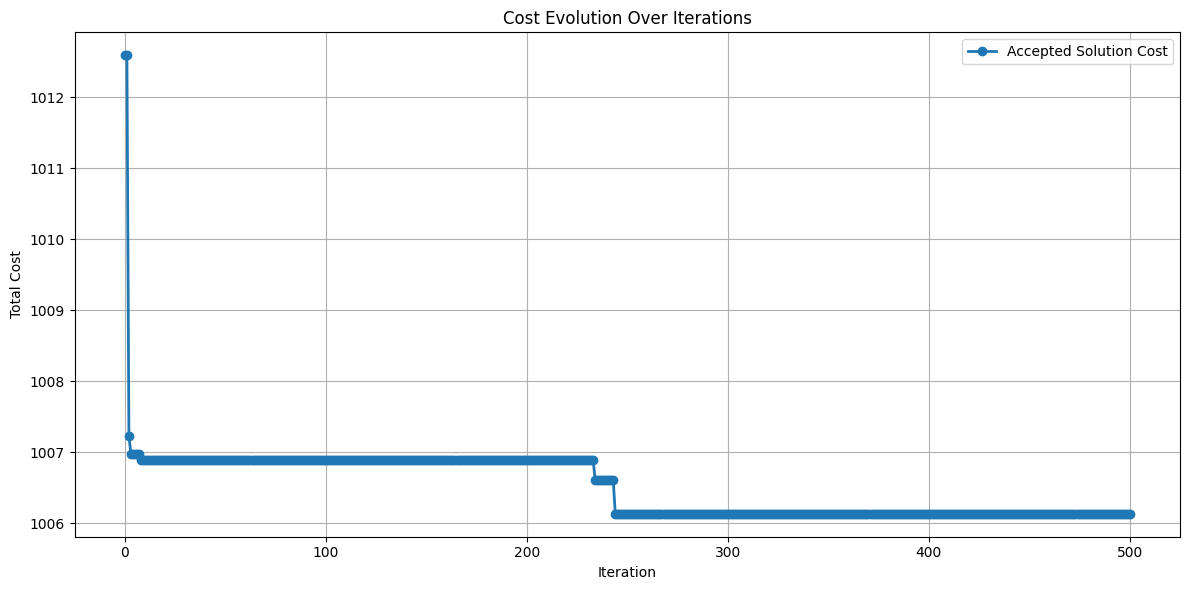

In [205]:
# Plot cost history and computed cost
plt.figure(figsize=(12, 6))
plt.plot(cost_history, marker='o', label='Accepted Solution Cost', linewidth=2)
plt.title("Cost Evolution Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Total Cost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

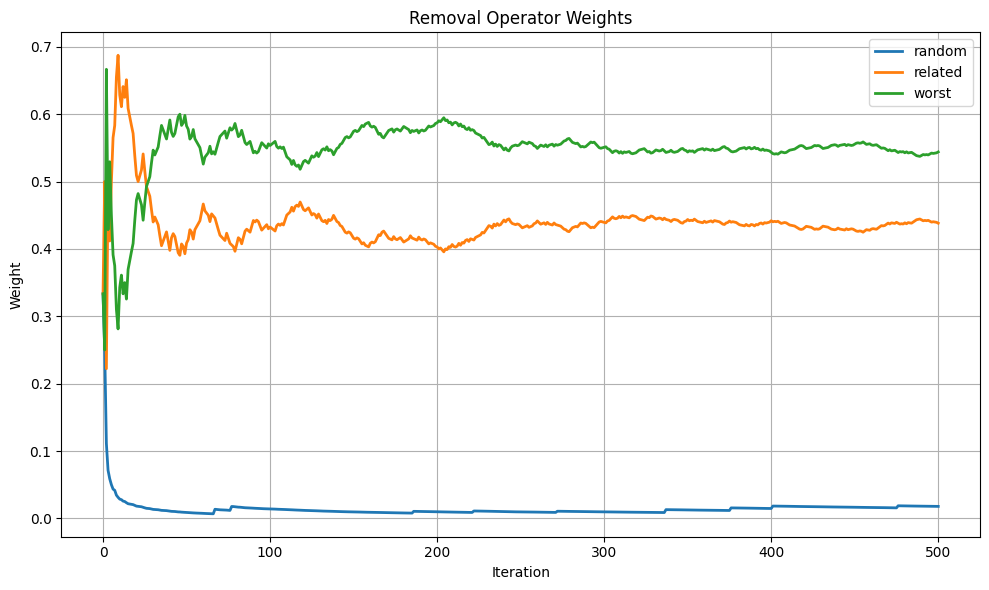

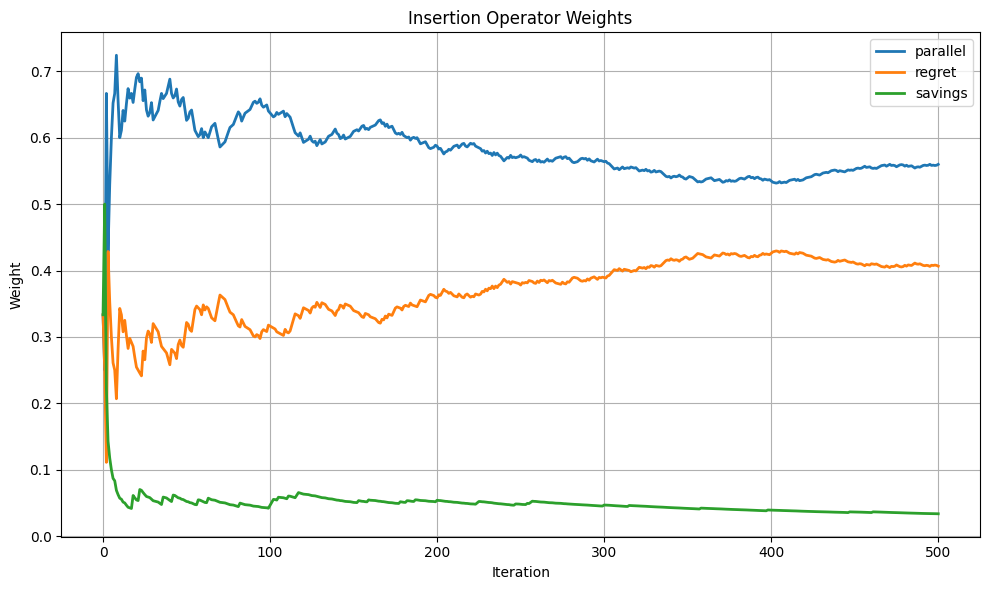

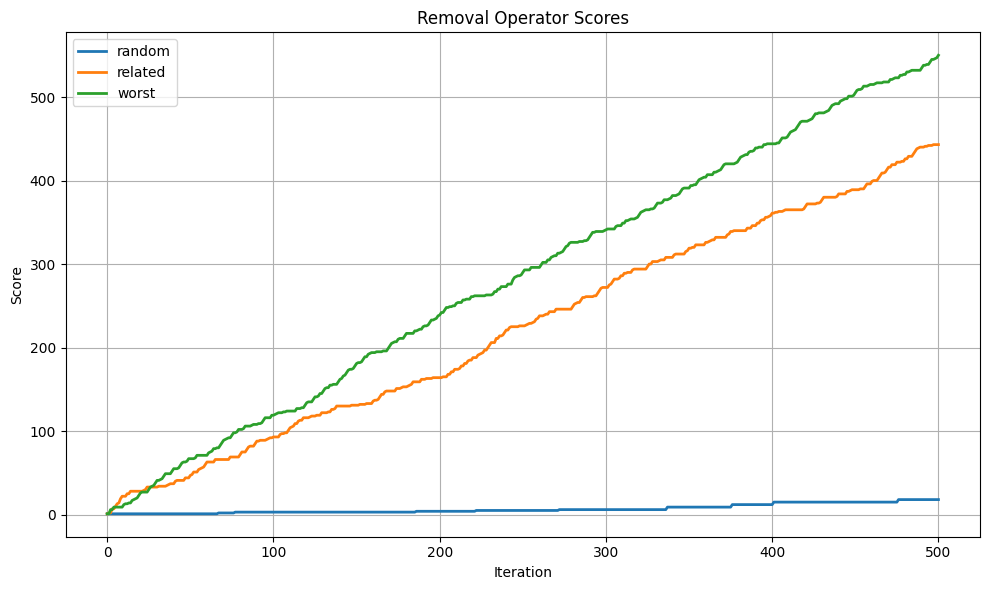

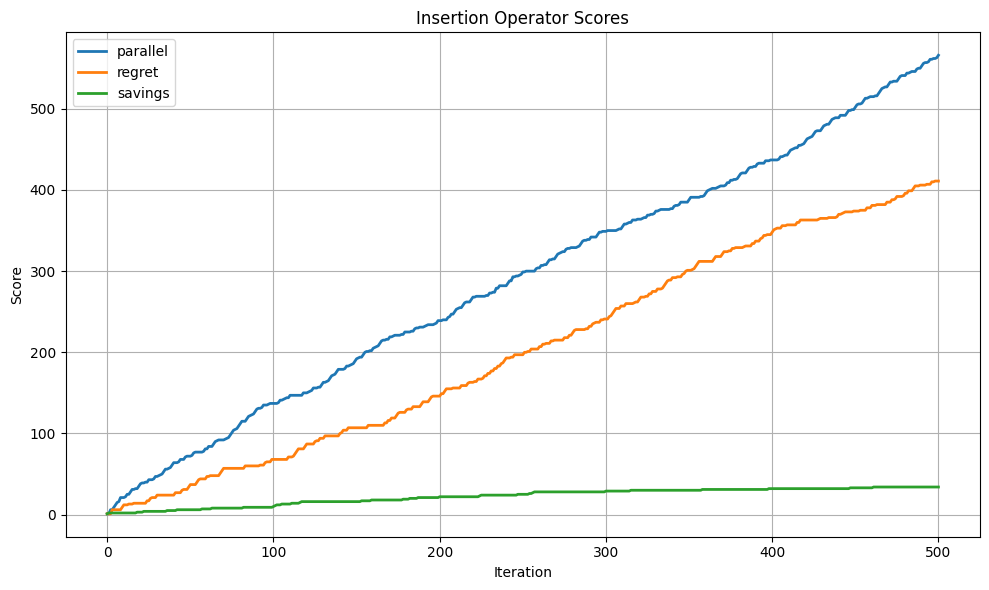

In [206]:
def plot_operator_stats(stat_history, title, ylabel):
    plt.figure(figsize=(10, 6))
    for op, values in stat_history.items():
        plt.plot(values, label=op, linewidth=2)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot operator stats
plot_operator_stats(removal_weights_history, "Removal Operator Weights", "Weight")
plot_operator_stats(insertion_weights_history, "Insertion Operator Weights", "Weight")
plot_operator_stats(removal_scores_history, "Removal Operator Scores", "Score")
plot_operator_stats(insertion_scores_history, "Insertion Operator Scores", "Score")